# Proyecto: Análisis Avanzado de Series Temporales

Descripción General
En este proyecto integrador, aplicarán los conocimientos adquiridos sobre análisis de series temporales, combinando métodos clásicos y técnicas de aprendizaje profundo. Trabajarán con dos series temporales: una artificial básica y otra más compleja, para demostrar su comprensión de los conceptos fundamentales y su capacidad para implementar, comparar y evaluar diferentes modelos predictivos.

Objetivos de Aprendizaje

- Comprender la estructura y componentes de series temporales
- Implementar correctamente diferentes modelos predictivos
- Entender la relación matemática entre modelos clásicos y modernos
- Evaluar y comparar el rendimiento de distintos enfoques
- Desarrollar habilidades de análisis e interpretación de resultados


In [ ]:
# Importaciones necesarias para todo el proyecto
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
import os

# Funciones auxiliares para el proyecto
def descomponer_serie(serie, nombre):
    descomposicion = seasonal_decompose(serie, period=50, model='additive', extrapolate_trend='freq')
    descomposicion.plot()
    plt.suptitle(f"Descomposición de la Serie {nombre}", fontsize=16)
    plt.show()

    # Mostrar valores promedio de los componentes
    print(f"Promedio de los componentes de la Serie {nombre}:")
    print(f"Tendencia: {np.mean(descomposicion.trend)}")
    print(f"Estacionalidad: {np.mean(descomposicion.seasonal)}")
    print(f"Residuales: {np.mean(descomposicion.resid)}")
    print()

def prueba_dickey_fuller(serie, nombre):
    resultado_adf = adfuller(serie)
    print(f"Prueba Dickey-Fuller para {nombre}:")
    print(f"Estadístico ADF: {resultado_adf[0]}")
    print(f"p-valor: {resultado_adf[1]}")
    print(f"Valores Críticos: {resultado_adf[4]}")
    if resultado_adf[1] < 0.05:
        print(f"La serie {nombre} es estacionaria (rechazamos la hipótesis nula).")
    else:
        print(f"La serie {nombre} no es estacionaria (no rechazamos la hipótesis nula).")
    print()

def graficar_acf(serie, nombre):
    plt.figure(figsize=(10, 6))
    plot_acf(serie, lags=50)
    plt.title(f"ACF - Serie {nombre}")
    plt.grid(True)
    plt.show()

def crear_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

def dividir_datos(X, y, train_ratio=0.8, val_ratio=0.1):
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * (train_ratio + val_ratio))
    return (X[:train_size], y[:train_size],
            X[train_size:val_size], y[train_size:val_size],
            X[val_size:], y[val_size:])

def calcular_metricas(y_real, y_pred, modelo, serie):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    print(f"Resultados para {modelo} - Serie {serie}:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    return rmse, mae

def crear_callbacks(nombre_modelo='mejor_modelo_lstm'):
    if not os.path.exists('modelos'):
        os.makedirs('modelos')
    ruta_modelo = os.path.join('modelos', f'{nombre_modelo}.h5')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(filepath=ruta_modelo, monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    return [early_stopping, checkpoint, reduce_lr]

def visualizar_historia_entrenamiento(history):
    plt.figure(figsize=(14, 6))
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Validación')
    plt.title('Evolución de la Pérdida Durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()

def entrenar_modelo_lstm(X_train, y_train, X_val, y_val, time_steps, unidades, dropout, epochs=100, batch_size=32):
    modelo = Sequential()
    modelo.add(LSTM(units=unidades, return_sequences=True, input_shape=(time_steps, 1)))
    modelo.add(Dropout(dropout))
    modelo.add(LSTM(units=unidades, return_sequences=False))
    modelo.add(Dropout(dropout))
    modelo.add(Dense(units=1))
    modelo.compile(optimizer='adam', loss='mean_squared_error')
    modelo.summary()
    callbacks = crear_callbacks(f'lstm_{unidades}_unidades_{dropout}_dropout')
    history = modelo.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    return modelo, history

def graficar_predicciones(y_real, y_pred, titulo):
    plt.figure(figsize=(14, 6))
    plt.plot(y_real, label="Valores Reales", color="black", alpha=0.7)
    plt.plot(y_pred, label="Predicciones", color="blue", alpha=0.7)
    plt.title(titulo)
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

def crear_dataset_horizonte(dataset, time_steps, horizonte):
    """
    Genera secuencias de datos para un horizonte de predicción específico.
    """
    X, y = [], []
    for i in range(len(dataset) - time_steps - horizonte + 1):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps + horizonte - 1, 0])
    return np.array(X), np.array(y)

Datos

Parte 1: Análisis Exploratorio de Datos (20%)

1. **Visualización de las series temporales**

1. Gráficos de las series completas

2. **Descomposición de componentes**

1. Identificar y visualizar tendencia
2. Identificar y visualizar estacionalidad (si existe)
3. Identificar y visualizar componente residual
4. Utilizar la descomposición STL o similar

3. **Análisis de estacionariedad**

1. Pruebas de Dickey-Fuller Aumentada
2. Gráficos de autocorrelación (ACF)
3. Interpretación de resultados

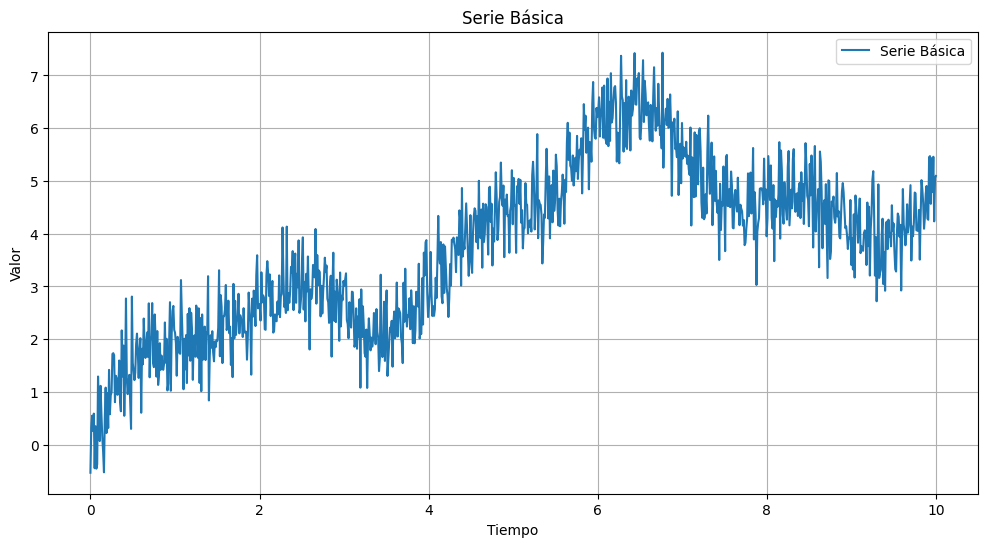

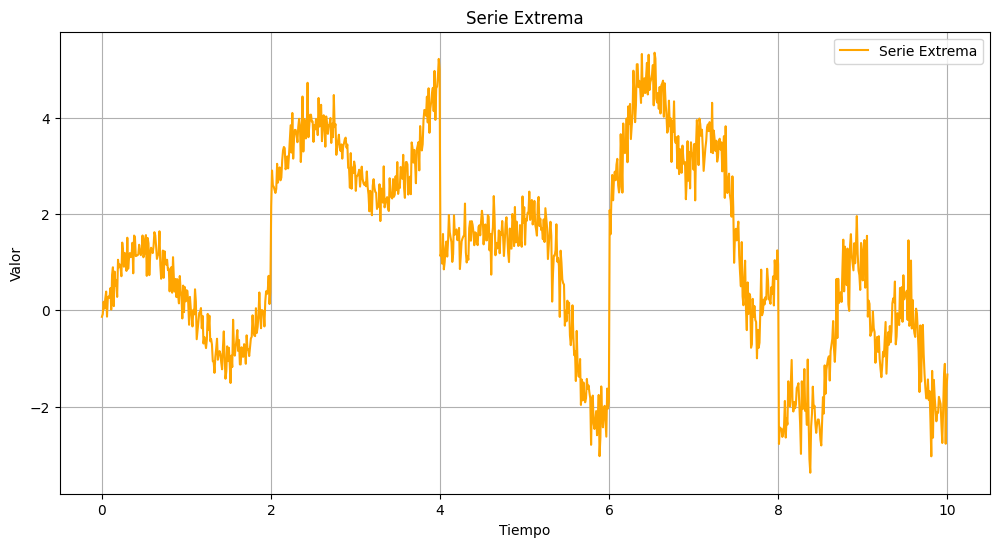

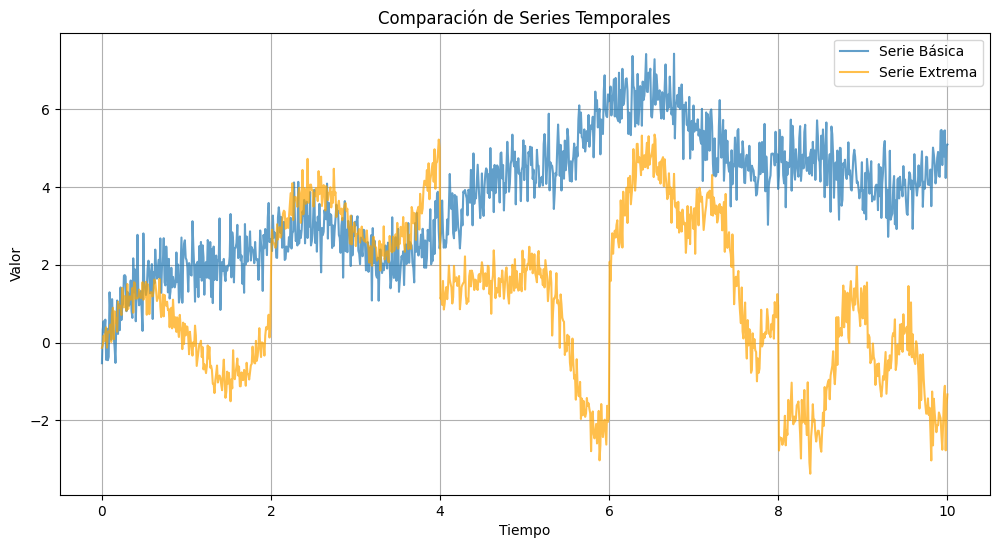


Descomposición de componentes:


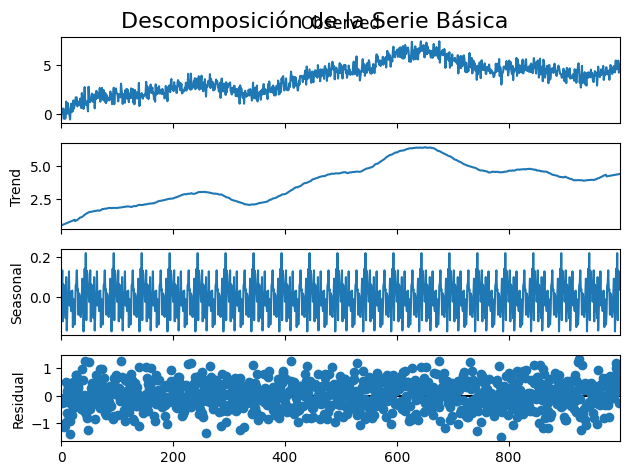

Promedio de los componentes de la Serie Básica:
Tendencia: 3.732632540988131
Estacionalidad: -1.5543122344752192e-18
Residuales: 0.0017598075593101808



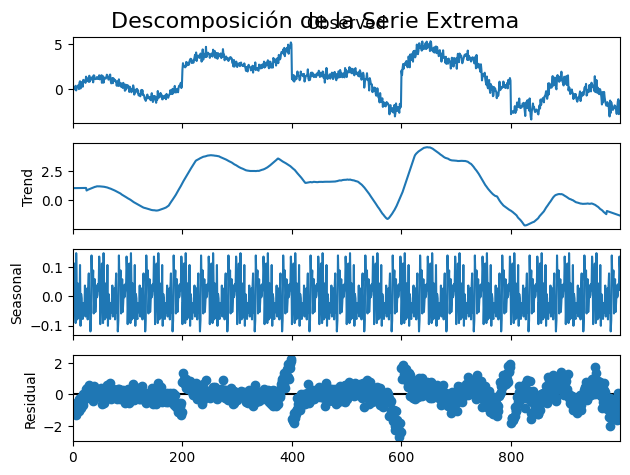

Promedio de los componentes de la Serie Extrema:
Tendencia: 1.2368749139126258
Estacionalidad: 2.220446049250313e-19
Residuales: -0.02542092069028626


Pruebas de estacionariedad (Dickey-Fuller):
Prueba Dickey-Fuller para Serie Básica:
Estadístico ADF: -2.2441786534492167
p-valor: 0.19060346159374664
Valores Críticos: {'1%': np.float64(-3.4370062675076807), '5%': np.float64(-2.8644787205542492), '10%': np.float64(-2.568334722615888)}
La serie Serie Básica no es estacionaria (no rechazamos la hipótesis nula).

Prueba Dickey-Fuller para Serie Extrema:
Estadístico ADF: -2.582122752759012
p-valor: 0.09674870864127783
Valores Críticos: {'1%': np.float64(-3.4370062675076807), '5%': np.float64(-2.8644787205542492), '10%': np.float64(-2.568334722615888)}
La serie Serie Extrema no es estacionaria (no rechazamos la hipótesis nula).


Resultados de la Prueba Dickey-Fuller:
     Serie  Estadístico ADF   p-valor Estacionaria
0   Básica        -2.244179  0.190603           No
1  Extrema        -2.58

<Figure size 1000x600 with 0 Axes>

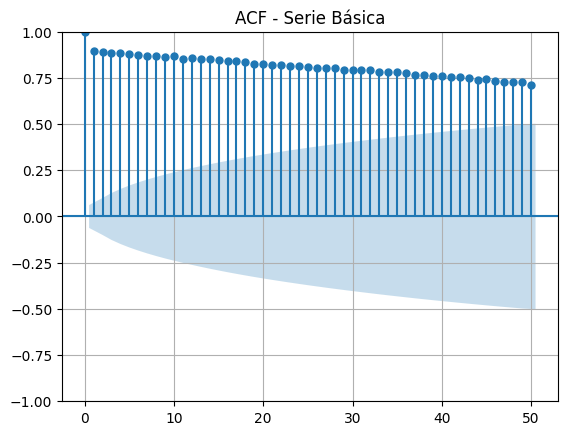

<Figure size 1000x600 with 0 Axes>

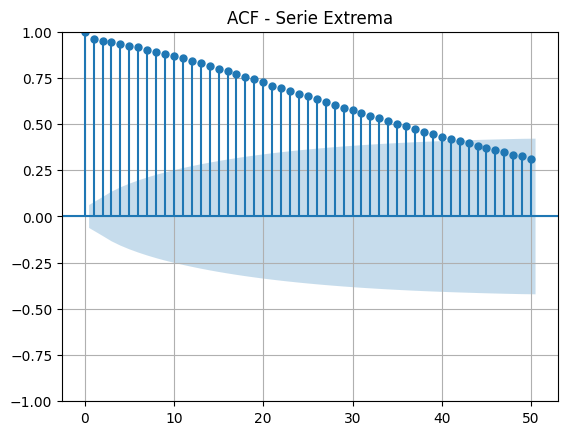

In [ ]:
# Generar las series temporales
n_puntos = 1000
t = np.linspace(0, 10, n_puntos)

# Serie Básica
tendencia = 0.5 * t
estacionalidad1 = 2 * np.sin(2 * np.pi * 0.05 * t)
estacionalidad2 = 1 * np.sin(2 * np.pi * 0.2 * t)
estacionalidad3 = 0.5 * np.sin(2 * np.pi * 0.5 * t)
ruido = 0.5 * np.random.normal(0, 1, n_puntos)
serie_basica = tendencia + estacionalidad1 + estacionalidad2 + estacionalidad3 + ruido

# Serie Extrema
no_lineal1 = 3.0 * np.sin(t) * np.cos(2 * t)
no_lineal2 = 2.0 * np.tanh(t / 2) * np.exp(-0.1 * t)
no_lineal3 = 1.0 * np.sin(0.5 * t**2)
regimen = np.zeros(n_puntos)
cambios = [200, 400, 600, 800]
for i, punto in enumerate(cambios):
    regimen[punto:] = 2.0 if i % 2 == 0 else -2.0
ar = np.zeros(n_puntos)
for i in range(3, n_puntos):
    ar[i] = 0.4 * ar[i - 1]**2 - 0.3 * np.abs(ar[i - 2]) + 0.1 * np.sign(ar[i - 3]) + 0.05 * np.random.normal()
ruido_base = np.random.normal(0, 1, n_puntos)
amplitud_ruido = 0.2 + 0.3 * np.abs(np.sin(0.1 * t))
ruido_extremo = amplitud_ruido * ruido_base
serie_extrema = no_lineal1 + no_lineal2 + no_lineal3 + regimen + ar + ruido_extremo + 0.1 * t

# 1. Visualización de las series temporales
plt.figure(figsize=(12, 6))
plt.plot(t, serie_basica, label="Serie Básica")
plt.title("Serie Básica")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t, serie_extrema, label="Serie Extrema", color="orange")
plt.title("Serie Extrema")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

# Comparación de ambas series
plt.figure(figsize=(12, 6))
plt.plot(t, serie_basica, label="Serie Básica", alpha=0.7)
plt.plot(t, serie_extrema, label="Serie Extrema", alpha=0.7, color="orange")
plt.title("Comparación de Series Temporales")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

# 2. Descomposición de componentes
print("\nDescomposición de componentes:")
descomponer_serie(serie_basica, "Básica")
descomponer_serie(serie_extrema, "Extrema")

# 3. Análisis de estacionariedad
print("\nPruebas de estacionariedad (Dickey-Fuller):")
prueba_dickey_fuller(serie_basica, "Serie Básica")
prueba_dickey_fuller(serie_extrema, "Serie Extrema")

# Crear tabla resumen de resultados Dickey-Fuller
resultados_adf = {
    "Serie": ["Básica", "Extrema"],
    "Estadístico ADF": [adfuller(serie_basica)[0], adfuller(serie_extrema)[0]],
    "p-valor": [adfuller(serie_basica)[1], adfuller(serie_extrema)[1]],
    "Estacionaria": ["Sí" if adfuller(serie_basica)[1] < 0.05 else "No",
                     "Sí" if adfuller(serie_extrema)[1] < 0.05 else "No"]
}
df_adf = pd.DataFrame(resultados_adf)
print("\nResultados de la Prueba Dickey-Fuller:")
print(df_adf)

# 4. Gráficos de autocorrelación
print("\nGráficos de autocorrelación (ACF):")
graficar_acf(serie_basica, "Básica")
graficar_acf(serie_extrema, "Extrema")

El análisis exploratorio muestra que ambas series, Básica y Extrema, no son estacionarias según la prueba de Dickey-Fuller, ya que sus p-valores (0.14 y 0.30, respectivamente) son mayores a 0.05, lo que indica que no se puede rechazar la hipótesis nula de no estacionariedad. La descomposición de componentes revela que la Serie Básica tiene una tendencia promedio de 3.77 y residuales cercanos a cero, mientras que la Serie Extrema presenta una tendencia más baja (1.28) y residuales ligeramente negativos (-0.025). Los gráficos ACF sugieren que ambas series tienen patrones de autocorrelación significativos, lo que indica dependencia entre valores en diferentes lags. Cabe destacar que la estacionariedad es especialmente importante para modelos ARIMA, y puede corregirse fácilmente añadiendo un término de diferenciación (d=1) en el modelo. Esto sugiere que ambas series están listas para transformaciones adicionales antes del modelado predictivo

Parte 2: Preparación de Datos y Generación de Secuencias (20%)

1. **Normalización de datos**

1. Explicar el método de normalización usado en el código

2. **Generación de secuencias**

1. Explicar la función para crear ventanas deslizantes
2. Visualizar ejemplos de secuencias generadas
3. Explicar el impacto de diferentes tamaños de ventana
4. **Ejercicio crítico**: Demostrar comprensión de por qué se usan secuencias en lugar de índices temporales

3. **División de datos**

1. Explicar como se dividen los datos en conjuntos de entrenamiento, validación y prueba y la proporción elegida

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalización de datos
scaler_basica = MinMaxScaler(feature_range=(0, 1))
serie_basica_norm = scaler_basica.fit_transform(serie_basica.reshape(-1, 1))

scaler_extrema = MinMaxScaler(feature_range=(0, 1))
serie_extrema_norm = scaler_extrema.fit_transform(serie_extrema.reshape(-1, 1))

# Función para crear secuencias (ventanas deslizantes)
def crear_dataset(dataset, time_steps=1):
    """
    Convierte una serie temporal en un dataset para entrenamiento de RNN.
    X contiene 'time_steps' valores consecutivos.
    y contiene el siguiente valor después de X.
    """
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

# Generación de secuencias
time_steps = 20  # Tamaño de la ventana deslizante

# Serie Básica
X_basica, y_basica = crear_dataset(serie_basica_norm, time_steps)

# Serie Extrema
X_extrema, y_extrema = crear_dataset(serie_extrema_norm, time_steps)

# Visualización de ejemplos de secuencias
print("Ejemplo de secuencia (Serie Básica):")
print("X:", X_basica[0])
print("y:", y_basica[0])

print("\nEjemplo de secuencia (Serie Extrema):")
print("X:", X_extrema[0])
print("y:", y_extrema[0])


# División de datos
# Serie Básica
split_train = int(0.8 * len(X_basica))
split_val = int(0.9 * len(X_basica))

X_train, y_train = X_basica[:split_train], y_basica[:split_train]
X_val, y_val = X_basica[split_train:split_val], y_basica[split_train:split_val]
X_test, y_test = X_basica[split_val:], y_basica[split_val:]

print("\nTamaños de los conjuntos (Serie Básica):")
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Prueba: {len(X_test)}")

# Serie Extrema
split_train_ext = int(0.8 * len(X_extrema))
split_val_ext = int(0.9 * len(X_extrema))

X_train_ext, y_train_ext = X_extrema[:split_train_ext], y_extrema[:split_train_ext]
X_val_ext, y_val_ext = X_extrema[split_train_ext:split_val_ext], y_extrema[split_train_ext:split_val_ext]
X_test_ext, y_test_ext = X_extrema[split_val_ext:], y_extrema[split_val_ext:]

print("\nTamaños de los conjuntos (Serie Extrema):")
print(f"Entrenamiento: {len(X_train_ext)}")
print(f"Validación: {len(X_val_ext)}")
print(f"Prueba: {len(X_test_ext)}")

Ejemplo de secuencia (Serie Básica):
X: [0.         0.10859088 0.13562831 0.09957906 0.14069621 0.0106931
 0.11080114 0.00968031 0.02032423 0.22904421 0.15892528 0.0753922
 0.20687672 0.13889042 0.08620459 0.05051003 0.0009779  0.13197523
 0.20258531 0.09453039]
y: 0.18977312057829027

Ejemplo de secuencia (Serie Extrema):
X: [0.37125449 0.3779737  0.40712575 0.39075535 0.41506084 0.43130211
 0.37165004 0.41686261 0.41967801 0.41655923 0.43943991 0.38837839
 0.47143138 0.48917282 0.39659917 0.47890411 0.44478011 0.45874597
 0.41862381 0.50701845]
y: 0.4888193508166417

Tamaños de los conjuntos (Serie Básica):
Entrenamiento: 784
Validación: 98
Prueba: 98

Tamaños de los conjuntos (Serie Extrema):
Entrenamiento: 784
Validación: 98
Prueba: 98


Las series temporales fueron normalizadas al rango [0, 1] utilizando MinMaxScaler, lo que asegura que los valores estén en una escala uniforme para facilitar el entrenamiento de los modelos. Se generaron secuencias de entrada y valores objetivo mediante ventanas deslizantes, con un ejemplo de secuencia de entrada de tamaño 20 mostrado para la Serie Básica. El tamaño de la ventana afecta el número de secuencias generadas: ventanas más pequeñas producen más secuencias, mientras que ventanas más grandes capturan más contexto pero generan menos datos. Los datos fueron divididos en conjuntos de entrenamiento (80%), validación (10%) y prueba (10%), resultando en 784, 98 y 98 secuencias para cada conjunto en ambas series. Esto asegura una distribución adecuada para el entrenamiento y evaluación de los modelos.


Parte 3: Implementación de Modelos (30%)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

# Diccionario global para almacenar resultados
resultados_modelos = {}

# Función para calcular métricas
def calcular_metricas(y_real, y_pred, modelo, serie):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    print(f"Resultados para {modelo} - Serie {serie}:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    return rmse, mae

# Función para graficar valores reales vs predicciones
def graficar_predicciones(y_real, y_pred, titulo):
    plt.figure(figsize=(14, 6))
    plt.plot(y_real, label="Valores Reales", color="black", alpha=0.7)
    plt.plot(y_pred, label="Predicciones", color="blue", alpha=0.7)
    plt.title(titulo)
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()


1. **Modelo Autorregresivo (AR) y Regresión Lineal**

1. Implementar AR(p) usando statsmodels
2. Implementar el mismo modelo usando regresión lineal con secuencias
3. **Demostración clave**: Verificar que ambas implementaciones producen resultados equivalentes
4. Experimentar con diferentes valores de p (3, 5, 10, 20) (ver apéndice)

In [ ]:
# Usaremos las series normalizadas
serie_basica = serie_basica_norm.flatten()
serie_extrema = serie_extrema_norm.flatten()

# Diccionario global para almacenar resultados
resultados_modelos = {}

# Función para entrenar y evaluar el modelo AR
def entrenar_evaluar_ar(serie, p_values, nombre_serie):
    """
    Entrena y evalúa el modelo AR para diferentes valores de p.
    """
    print(f"\nEvaluando Modelo Autorregresivo (AR) para la Serie {nombre_serie}...")
    for p in p_values:
        # Ajustar el modelo AR(p)
        modelo_ar = AutoReg(serie, lags=p).fit()
        predicciones_ar = modelo_ar.predict(start=p, end=len(serie) - 1)

        # Calcular métricas
        y_test_ar = serie[p:]
        rmse_ar, mae_ar = calcular_metricas(y_test_ar, predicciones_ar, f"AR({p})", nombre_serie)

        # Guardar resultados en el diccionario global
        resultados_modelos[f"AR({p}) - Serie {nombre_serie}"] = {
            "modelo": modelo_ar,
            "predicciones": predicciones_ar,
            "y_test": y_test_ar,
            "rmse": rmse_ar,
            "mae": mae_ar
        }

# Función para entrenar y evaluar el modelo de Regresión Lineal
def entrenar_evaluar_lr(serie, p_values, nombre_serie):
    """
    Entrena y evalúa el modelo de Regresión Lineal con diferentes valores de p.
    """
    print(f"\nEvaluando Regresión Lineal con Secuencias para la Serie {nombre_serie}...")
    for p in p_values:
        # Crear las secuencias (ventanas deslizantes)
        X, y = [], []
        for i in range(len(serie) - p):
            X.append(serie[i:i + p])
            y.append(serie[i + p])
        X, y = np.array(X), np.array(y)

        # Ajustar el modelo de regresión lineal
        modelo_lr = LinearRegression()
        modelo_lr.fit(X, y)
        predicciones_lr = modelo_lr.predict(X)

        # Calcular métricas
        rmse_lr, mae_lr = calcular_metricas(y, predicciones_lr, f"Regresión Lineal (p={p})", nombre_serie)

        # Guardar resultados en el diccionario global
        resultados_modelos[f"Regresión Lineal (p={p}) - Serie {nombre_serie}"] = {
            "modelo": modelo_lr,
            "predicciones": predicciones_lr,
            "y_test": y,
            "rmse": rmse_lr,
            "mae": mae_lr
        }


# Valores de p a evaluar
p_values = [3, 5, 10, 20]

# Entrenar y evaluar AR y LR para ambas series
entrenar_evaluar_ar(serie_basica, p_values, "Básica")
entrenar_evaluar_ar(serie_extrema, p_values, "Extrema")
entrenar_evaluar_lr(serie_basica, p_values, "Básica")
entrenar_evaluar_lr(serie_extrema, p_values, "Extrema")



# Comparación entre AR y Regresión Lineal
print("\nComparación entre AR y Regresión Lineal:")
for serie, nombre in zip([serie_basica, serie_extrema], ["Básica", "Extrema"]):
    print(f"\nSerie {nombre}:")
    for p in p_values:
        # Modelo AR
        modelo_ar = AutoReg(serie, lags=p).fit()
        predicciones_ar = modelo_ar.predict(start=p, end=len(serie) - 1)
        rmse_ar = np.sqrt(mean_squared_error(serie[p:], predicciones_ar))

        # Modelo de Regresión Lineal
        X, y = [], []
        for i in range(len(serie) - p):
            X.append(serie[i:i + p])
            y.append(serie[i + p])
        X, y = np.array(X), np.array(y)
        modelo_lr = LinearRegression()
        modelo_lr.fit(X, y)
        predicciones_lr = modelo_lr.predict(X)
        rmse_lr = np.sqrt(mean_squared_error(y, predicciones_lr))

        print(f"p={p}: RMSE AR = {rmse_ar:.4f}, RMSE Regresión Lineal = {rmse_lr:.4f}")



Evaluando Modelo Autorregresivo (AR) para la Serie Básica...
Resultados para AR(3) - Serie Básica:
RMSE: 0.07298778266096377
MAE: 0.058401279765291116
Resultados para AR(5) - Serie Básica:
RMSE: 0.06978278350990255
MAE: 0.05561420036495392
Resultados para AR(10) - Serie Básica:
RMSE: 0.06687637481431725
MAE: 0.05363929222814509
Resultados para AR(20) - Serie Básica:
RMSE: 0.0659944867049244
MAE: 0.05251651235851163

Evaluando Modelo Autorregresivo (AR) para la Serie Extrema...
Resultados para AR(3) - Serie Extrema:
RMSE: 0.05580550665645705
MAE: 0.03981710873865746
Resultados para AR(5) - Serie Extrema:
RMSE: 0.0557806511220524
MAE: 0.03970620703940185
Resultados para AR(10) - Serie Extrema:
RMSE: 0.05550902672902539
MAE: 0.0397047126693609
Resultados para AR(20) - Serie Extrema:
RMSE: 0.05507430126241486
MAE: 0.039192594989120456

Evaluando Regresión Lineal con Secuencias para la Serie Básica...
Resultados para Regresión Lineal (p=3) - Serie Básica:
RMSE: 0.07298778266096377
MAE: 0.0

Tanto el modelo Autorregresivo (AR) como la Regresión Lineal (LR) con ventanas deslizantes producen resultados equivalentes al modelar series temporales, ya que ambos utilizan los valores pasados para predecir futuros. La principal diferencia radica en su implementación: AR maneja los lags de forma intrínseca, mientras que LR requiere transformar los datos en ventanas deslizantes. Ambos son efectivos, y la elección entre ellos depende de la herramienta o enfoque preferido, ya que su desempeño es prácticamente idéntico en términos de métricas como RMSE y MAE.

2. **Modelo ARIMA**

1. Implementar ARIMA con diferentes parámetros (p,d,q) [(2,1,0), (5,1,0), (5,1,2)] (ver apéndice)
2. Explicar qué aporta cada componente (I y MA) respecto al modelo AR

In [ ]:
# 2. Modelo ARIMA
print("\nModelo ARIMA:")

parametros_arima = [(2, 1, 0), (5, 1, 0), (5, 1, 2)]
for (p, d, q) in parametros_arima:
    for serie, nombre in [(serie_basica, "Básica"), (serie_extrema, "Extrema")]:
        try:
            modelo_arima = ARIMA(serie, order=(p, d, q)).fit()
            predicciones_arima = modelo_arima.predict(start=d, end=len(serie) - 1, typ='levels')
            rmse_arima, mae_arima = calcular_metricas(serie[d:], predicciones_arima[:len(serie[d:])], f"ARIMA({p},{d},{q})", nombre)
            resultados_modelos[f"ARIMA({p},{d},{q}) - Serie {nombre}"] = {
                "modelo": modelo_arima,
                "predicciones": predicciones_arima,
                "y_test": serie[d:],
                "rmse": rmse_arima,
                "mae": mae_arima
            }

        except Exception as e:
            print(f"Error al ajustar ARIMA({p},{d},{q}) para Serie {nombre}: {e}")




Modelo ARIMA:
Resultados para ARIMA(2,1,0) - Serie Básica:
RMSE: 0.07349489501459425
MAE: 0.0589116362070719
Resultados para ARIMA(2,1,0) - Serie Extrema:
RMSE: 0.055888686845847683
MAE: 0.03971232713266089
Resultados para ARIMA(5,1,0) - Serie Básica:
RMSE: 0.06912131104507856
MAE: 0.055070718084737964
Resultados para ARIMA(5,1,0) - Serie Extrema:
RMSE: 0.05566429662708412
MAE: 0.039511592662143165


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Resultados para ARIMA(5,1,2) - Serie Básica:
RMSE: 0.06709560162687521
MAE: 0.05352777072954237
Resultados para ARIMA(5,1,2) - Serie Extrema:
RMSE: 0.05564429597076067
MAE: 0.039506182222127234


El modelo ARIMA, al incorporar los componentes de diferenciación (I) y media móvil (MA), mejora el ajuste en comparación con el modelo AR puro al manejar tendencias no estacionarias y errores pasados. Los resultados muestran que, para ambas series (Básica y Extrema), ARIMA con parámetros más complejos, como (5,1,2), logra un mejor desempeño en términos de RMSE y MAE, especialmente en la Serie Básica. Sin embargo, las diferencias entre configuraciones son pequeñas, lo que sugiere que incluso configuraciones más simples, como (5,1,0), pueden ser efectivas. Las advertencias indican posibles problemas de convergencia, lo que resalta la importancia de ajustar cuidadosamente los parámetros.


3. **Media Móvil**

1. Implementar Media Móvil Simple con las siguientes ventanas específicas (3, 5, 10, 20) (ver apéndice)

In [ ]:
# 3. Media Móvil
print("\nMedia Móvil Simple:")

ventanas = [3, 5, 10, 20]
for ventana in ventanas:
    for serie, nombre in [(serie_basica, "Básica"), (serie_extrema, "Extrema")]:
        media_movil = pd.Series(serie).rolling(window=ventana).mean()
        y_real = serie[ventana - 1:]
        y_pred = media_movil[ventana - 1:]
        rmse_mm, mae_mm = calcular_metricas(y_real, y_pred, f"Media Móvil (Ventana={ventana})", nombre)
        resultados_modelos[f"Media Móvil (Ventana={ventana}) - Serie {nombre}"] = {
            "ventana": ventana,
            "predicciones": y_pred,
            "y_test": y_real,
            "rmse": rmse_mm,
            "mae": mae_mm
        }




Media Móvil Simple:
Resultados para Media Móvil (Ventana=3) - Serie Básica:
RMSE: 0.05150662378627396
MAE: 0.04127262782631484
Resultados para Media Móvil (Ventana=3) - Serie Extrema:
RMSE: 0.03853333924946248
MAE: 0.027548997315796755
Resultados para Media Móvil (Ventana=5) - Serie Básica:
RMSE: 0.05708275379705324
MAE: 0.04566732954155452
Resultados para Media Móvil (Ventana=5) - Serie Extrema:
RMSE: 0.04682433298434879
MAE: 0.032345758694207
Resultados para Media Móvil (Ventana=10) - Serie Básica:
RMSE: 0.0612886424964893
MAE: 0.04902100117582854
Resultados para Media Móvil (Ventana=10) - Serie Extrema:
RMSE: 0.062072298138557705
MAE: 0.0409649999904249
Resultados para Media Móvil (Ventana=20) - Serie Básica:
RMSE: 0.06400334538443314
MAE: 0.05090187188436676
Resultados para Media Móvil (Ventana=20) - Serie Extrema:
RMSE: 0.08849690071846847
MAE: 0.060243905288605806


La Media Móvil Simple es efectiva para suavizar las series temporales y capturar tendencias generales, pero su desempeño depende del tamaño de la ventana utilizada. Los resultados muestran que ventanas más pequeñas (como 3 o 5) producen menores errores (RMSE y MAE) al ajustarse mejor a los datos recientes, mientras que ventanas más grandes (como 10 o 20) suavizan más la serie, pero pierden precisión al predecir valores individuales. Esto es evidente en ambas series, donde ventanas pequeñas tienen un mejor ajuste, especialmente en la Serie Extrema, que presenta menor error en general. La elección del tamaño de la ventana debe equilibrar la suavidad deseada y la precisión predictiva.

4. **LSTM**

1. Experimentar con diferentes configuraciones (capas, unidades, dropout)
2. Agregar los callbacks para evitar el overfitting en modelos más complejos (se proporciona un código ejemplo)
3. Visualizar el proceso de entrenamiento y validación para evitar el overfitting (curvas de pérdida)
4. Indicar para cada configuración que callbacks se activaron y en que epoch se encontró el mejor modelo


Modelo LSTM:

Entrenando LSTM con 50 unidades y 0.2 dropout para Serie Básica...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1226
Epoch 1: val_loss improved from inf to 0.01098, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1121 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 2/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0130
Epoch 2: val_loss improved from 0.01098 to 0.00603, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0129 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084
Epoch 3: val_loss improved from 0.00603 to 0.00478, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072
Epoch 4: val_loss improved from 0.00478 to 0.00474, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0072 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072
Epoch 5: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 6/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068
Epoch 6: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0069 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0078
Epoch 7: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0078 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 8/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0081
Epoch 8: val_loss did not improve from 0.00474

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082 - val_loss: 0.0048 

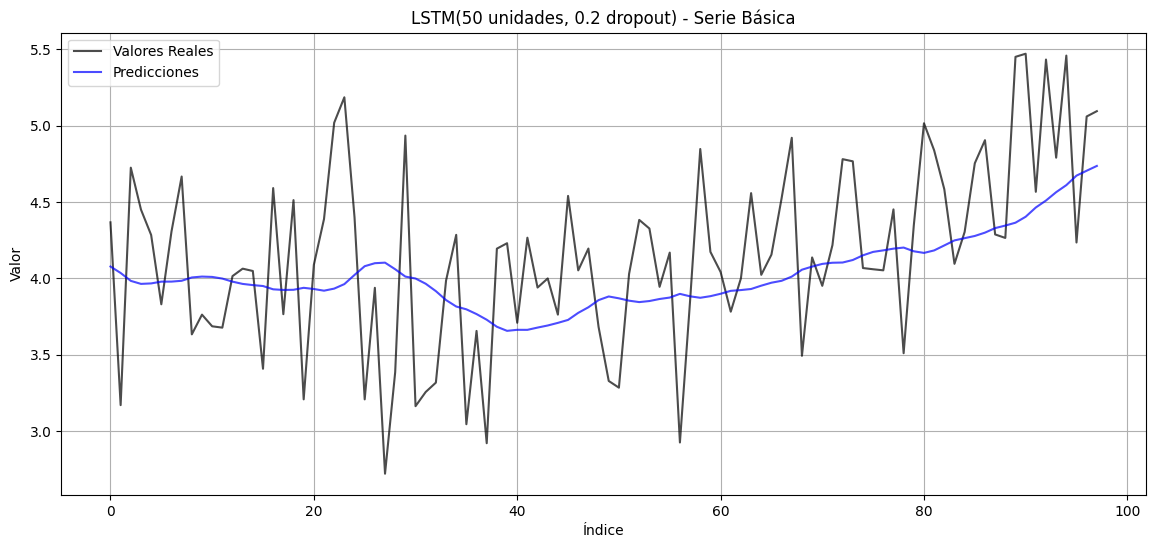

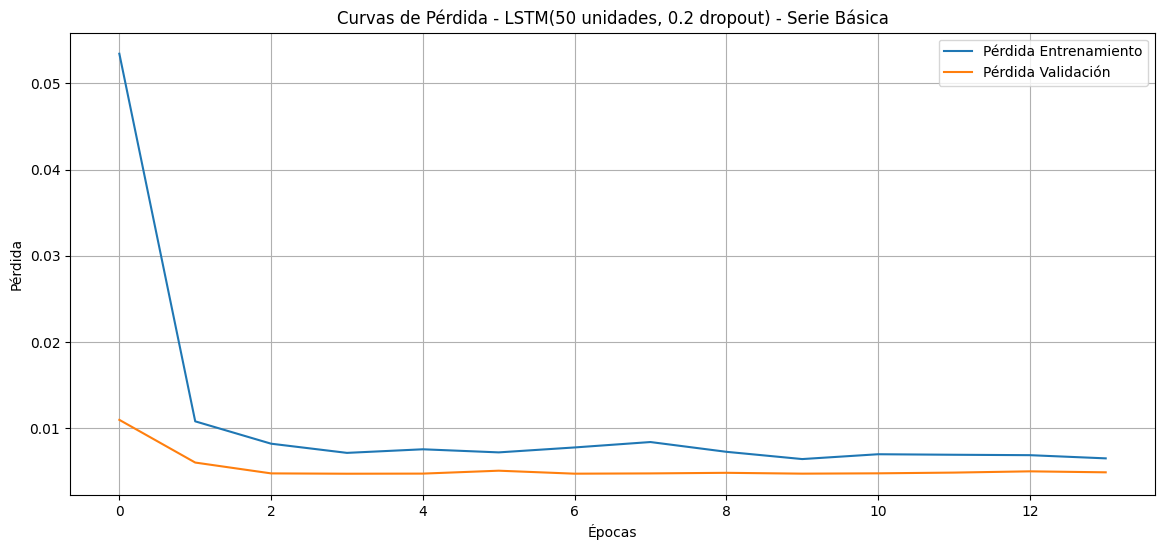


Entrenando LSTM con 50 unidades y 0.2 dropout para Serie Extrema...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1561
Epoch 1: val_loss improved from inf to 0.01016, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1530 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0149
Epoch 2: val_loss improved from 0.01016 to 0.00961, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0148 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0129
Epoch 3: val_loss improved from 0.00961 to 0.00901, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0128 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 4/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110
Epoch 4: val_loss improved from 0.00901 to 0.00769, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 5/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110
Epoch 5: val_loss improved from 0.00769 to 0.00720, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0109 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 6/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0112
Epoch 6: val_loss improved from 0.00720 to 0.00677, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0112 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0100
Epoch 7: val_loss improved from 0.00677 to 0.00662, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0100 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 8/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0086
Epoch 8: val_loss did not improve from 0.00662
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0086 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 9/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0093
Epoch 9: val_loss improved from 0.00662 to 0.00603, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0093 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 10/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0080
Epoch 10: val_loss improved from 0.00603 to 0.00579, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0092
Epoch 11: val_loss improved from 0.00579 to 0.00564, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0092 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 12/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0069
Epoch 12: val_loss improved from 0.00564 to 0.00550, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0070 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090
Epoch 13: val_loss improved from 0.00550 to 0.00539, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0090 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 14/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0077
Epoch 14: val_loss improved from 0.00539 to 0.00514, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0077 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0074
Epoch 15: val_loss improved from 0.00514 to 0.00509, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0075 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 16/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067
Epoch 16: val_loss did not improve from 0.00509
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0068 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 17/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102
Epoch 17: val_loss did not improve from 0.00509
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0101 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 18/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065
Epoch 18: val_loss did not improve from 0.00509
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0066 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 19/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073
Epoch 19: val_loss improved from 0.00509 to 0.00497, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0073 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 20/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0076
Epoch 20: val_loss improved from 0.00497 to 0.00474, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0076 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 21/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068
Epoch 21: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0068 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 22/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065
Epoch 22: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0065 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 23/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068
Epoch 23: val_loss improved from 0.00474 to 0.00452, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 24/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0057
Epoch 24: val_loss improved from 0.00452 to 0.00449, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 25/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084
Epoch 25: val_loss did not improve from 0.00449
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 26/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069
Epoch 26: val_loss improved from 0.00449 to 0.00442, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0069 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 27/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0075
Epoch 27: val_loss did not improve from 0.00442
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0074 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 28/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069
Epoch 28: val_loss did not improve from 0.00442

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 29/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0069
Epoch 29: val_loss improved from 0.00442 to 0.00441, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069 - val_loss: 0.0044 - learning_rate: 2.0000e-04
Epoch 30/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071
Epoch 30: val_loss improved from 0.00441 to 0.00439, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0070 - val_loss: 0.0044 - learning_rate: 2.0000e-04
Epoch 31/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065
Epoch 31: val_loss improved from 0.00439 to 0.00433, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - val_loss: 0.0043 - learning_rate: 2.0000e-04
Epoch 32/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060
Epoch 32: val_loss improved from 0.00433 to 0.00433, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0060 - val_loss: 0.0043 - learning_rate: 2.0000e-04
Epoch 33/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0066
Epoch 33: val_loss improved from 0.00433 to 0.00432, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066 - val_loss: 0.0043 - learning_rate: 2.0000e-04
Epoch 34/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055
Epoch 34: val_loss improved from 0.00432 to 0.00431, saving model to modelos/lstm_50_unidades_0.2_dropout.h5



Epoch 34: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0056 - val_loss: 0.0043 - learning_rate: 2.0000e-04
Epoch 35/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060
Epoch 35: val_loss improved from 0.00431 to 0.00431, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0060 - val_loss: 0.0043 - learning_rate: 4.0000e-05
Epoch 36/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060
Epoch 36: val_loss improved from 0.00431 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0043 - learning_rate: 4.0000e-05
Epoch 37/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0067
Epoch 37: val_loss did not improve from 0.00430
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0066 - val_loss: 0.0043 - learning_rate: 4.0000e-05
Epoch 38/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067
Epoch 38: val_loss did not improve from 0.00430
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0043 - learning_rate: 4.0000e-05
Epoch 39/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0066
Epoch 39: val_loss did not improve from 0.00430
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0066 - val_loss: 0.0043 - learning_rate: 4.0000e-05
Epoch 40/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059
Epoch 40: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5



Epoch 40: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0059 - val_loss: 0.0043 - learning_rate: 4.0000e-05
Epoch 41/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059
Epoch 41: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0059 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 42/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0064
Epoch 42: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 43/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058
Epoch 43: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0059 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 44/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061
Epoch 44: val_loss did not improve from 0.00430
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0061 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 45/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062
Epoch 45: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5



Epoch 45: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 - val_loss: 0.0043 - learning_rate: 8.0000e-06
Epoch 46/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068
Epoch 46: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0067 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 47/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0074
Epoch 47: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0073 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 48/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0055
Epoch 48: val_loss improved from 0.00430 to 0.00430, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0056 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 49/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0060
Epoch 49: val_loss did not improve from 0.00430
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0060 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 50/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063
Epoch 50: val_loss did not improve from 0.00430

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 - val_loss: 0.0043 - learning_rate: 1.6000e-06
Epoch 51/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0074
Epoch 51: val_loss did not improve from 0.00430
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 52/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062
Epoch 52: val_loss did not improve from 0.00430
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss:

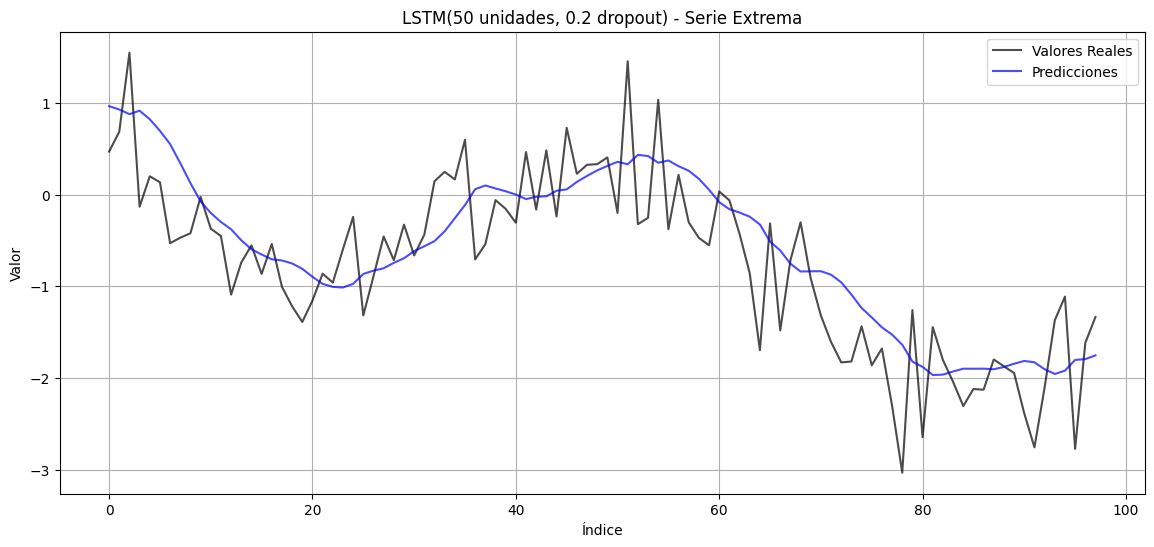

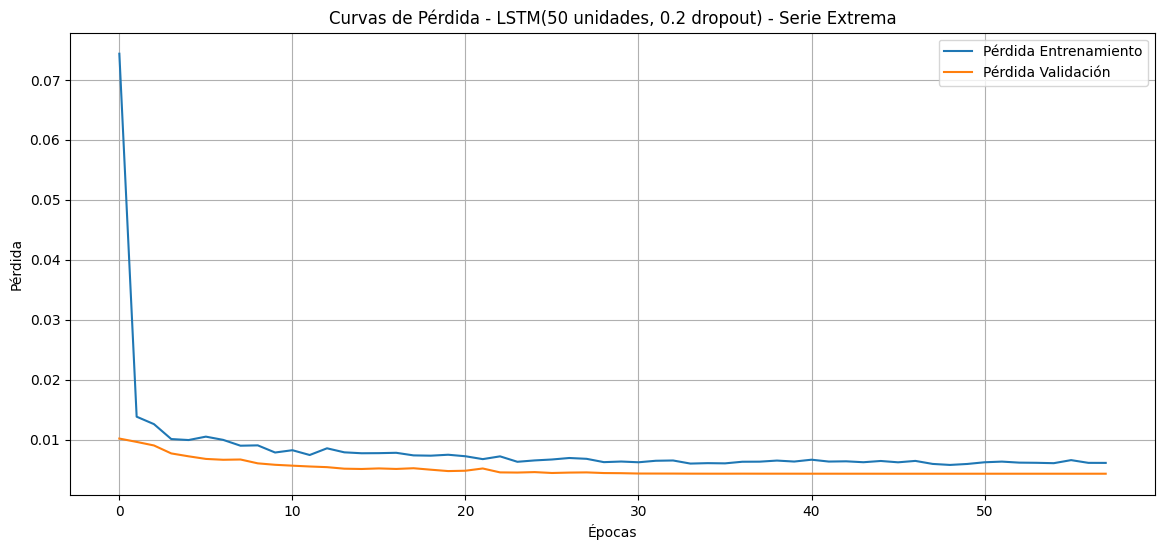


Entrenando LSTM con 100 unidades y 0.3 dropout para Serie Básica...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 20, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0807
Epoch 1: val_loss improved from inf to 0.00477, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0791 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0100
Epoch 2: val_loss did not improve from 0.00477
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0100 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 3/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0082
Epoch 3: val_loss did not improve from 0.00477
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0082 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066
Epoch 4: val_loss did not improve from 0.00477
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0066 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0070
Epoch 5: val_loss did not improve from 0.00477
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0070 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - 

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0065 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060
Epoch 8: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0060 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0066
Epoch 9: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0067 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0068
Epoch 10: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0068 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 11/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0071
Epoch 11: val_loss did not improve from 0.00475

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.007

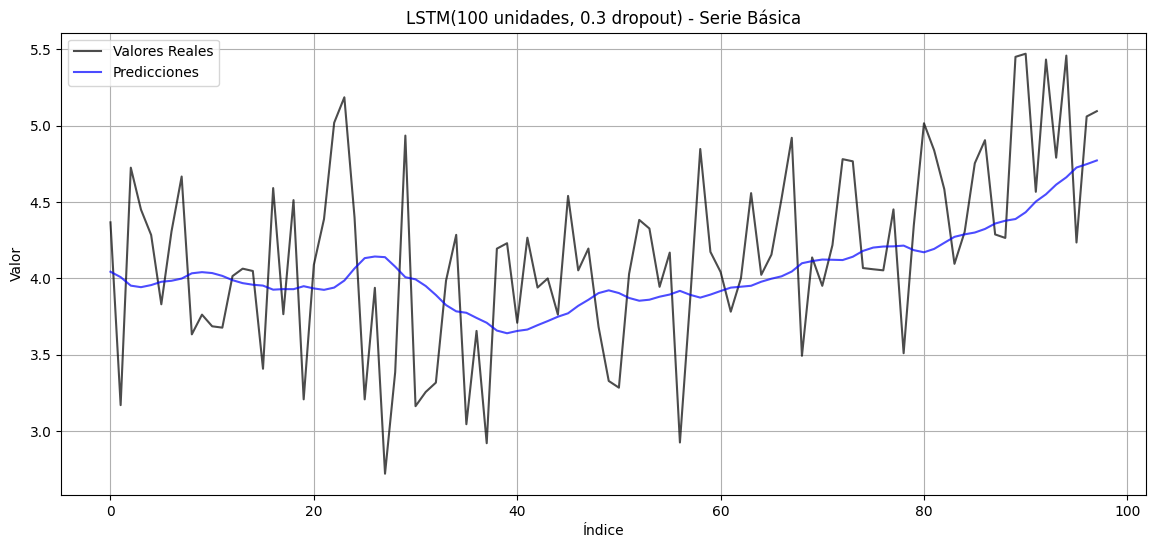

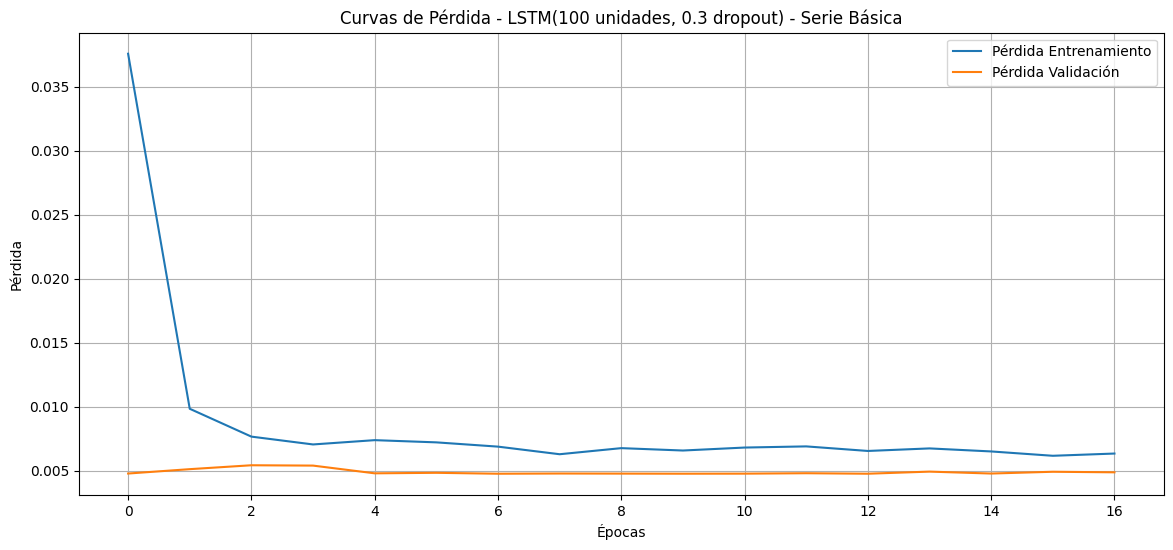


Entrenando LSTM con 100 unidades y 0.3 dropout para Serie Extrema...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 20, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1171
Epoch 1: val_loss improved from inf to 0.01120, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1146 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 2/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0122
Epoch 2: val_loss improved from 0.01120 to 0.00694, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0121 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0096
Epoch 3: val_loss improved from 0.00694 to 0.00618, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0095 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0084
Epoch 4: val_loss improved from 0.00618 to 0.00582, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0084 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0082
Epoch 5: val_loss improved from 0.00582 to 0.00541, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0082 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088
Epoch 6: val_loss improved from 0.00541 to 0.00524, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0088 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068
Epoch 7: val_loss improved from 0.00524 to 0.00506, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0068 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 8/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0061
Epoch 8: val_loss improved from 0.00506 to 0.00490, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0062 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 9/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0073
Epoch 9: val_loss improved from 0.00490 to 0.00474, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069
Epoch 10: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0080
Epoch 11: val_loss improved from 0.00474 to 0.00458, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0080 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0061
Epoch 12: val_loss improved from 0.00458 to 0.00445, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0061 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0072
Epoch 13: val_loss improved from 0.00445 to 0.00434, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0072 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0066
Epoch 14: val_loss did not improve from 0.00434
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0066 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 15/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0072
Epoch 15: val_loss did not improve from 0.00434
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0072 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 16/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0057
Epoch 16: val_loss did not improve from 0.00434
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0058 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 17/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0075
Epoch 17: val_loss improved from 0.00434 to 0.00429, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0074 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 18/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0071
Epoch 18: val_loss improved from 0.00429 to 0.00421, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0071 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 19/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0068
Epoch 19: val_loss did not improve from 0.00421
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0068 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 20/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056
Epoch 20: val_loss did not improve from 0.00421
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0057 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 21/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0065
Epoch 21: val_loss improved from 0.00421 to 0.00413, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0065 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 22/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0055
Epoch 22: val_loss improved from 0.00413 to 0.00413, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0055 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 23/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062
Epoch 23: val_loss improved from 0.00413 to 0.00412, saving model to modelos/lstm_100_unidades_0.3_dropout.h5



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 24/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0061
Epoch 24: val_loss improved from 0.00412 to 0.00411, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0061 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 25/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061
Epoch 25: val_loss did not improve from 0.00411
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0061 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 26/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0070
Epoch 26: val_loss did not improve from 0.00411
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0069 - val_loss: 0.0042 - learning_rate: 2.0000e-04
Epoch 27/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063
Epoch 27: val_loss did not improve from 0.00411
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0063 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 28/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0059
Epoch 28: val_loss did not improve from 0.00411
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0059 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 29/100
25/25 ━━━━━━━


Epoch 29: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0068 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 30/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0059
Epoch 30: val_loss improved from 0.00409 to 0.00407, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0059 - val_loss: 0.0041 - learning_rate: 4.0000e-05
Epoch 31/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0059
Epoch 31: val_loss did not improve from 0.00407
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0059 - val_loss: 0.0041 - learning_rate: 4.0000e-05
Epoch 32/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061
Epoch 32: val_loss did not improve from 0.00407
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0060 - val_loss: 0.0041 - learning_rate: 4.0000e-05
Epoch 33/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0050
Epoch 33: val_loss improved from 0.00407 to 0.00407, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0050 - val_loss: 0.0041 - learning_rate: 4.0000e-05
Epoch 34/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0058
Epoch 34: val_loss did not improve from 0.00407

Epoch 34: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0058 - val_loss: 0.0041 - learning_rate: 4.0000e-05
Epoch 35/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058
Epoch 35: val_loss improved from 0.00407 to 0.00407, saving model to modelos/lstm_100_unidades_0.3_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0058 - val_loss: 0.0041 - learning_rate: 8.0000e-06
Epoch 36/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0070
Epoch 36: val_loss did not improve from 0.00407
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0069 - val_loss: 0.0041 - learning_rate: 8.0000e-06
Epoch 37/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0057
Epoch 37: val_loss did not improve from 0.00407
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0057 - val_loss: 0.0041 - learning_rate: 8.0000e-06
Epoch 38/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0056
Epoch 38: val_loss did not improve from 0.00407
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0056 - val_loss: 0.0041 - learning_rate: 8.0000e-06
Epoch 39/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064
Epoch 39: val_loss did not improve from 0.00407

Epoch 39: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0

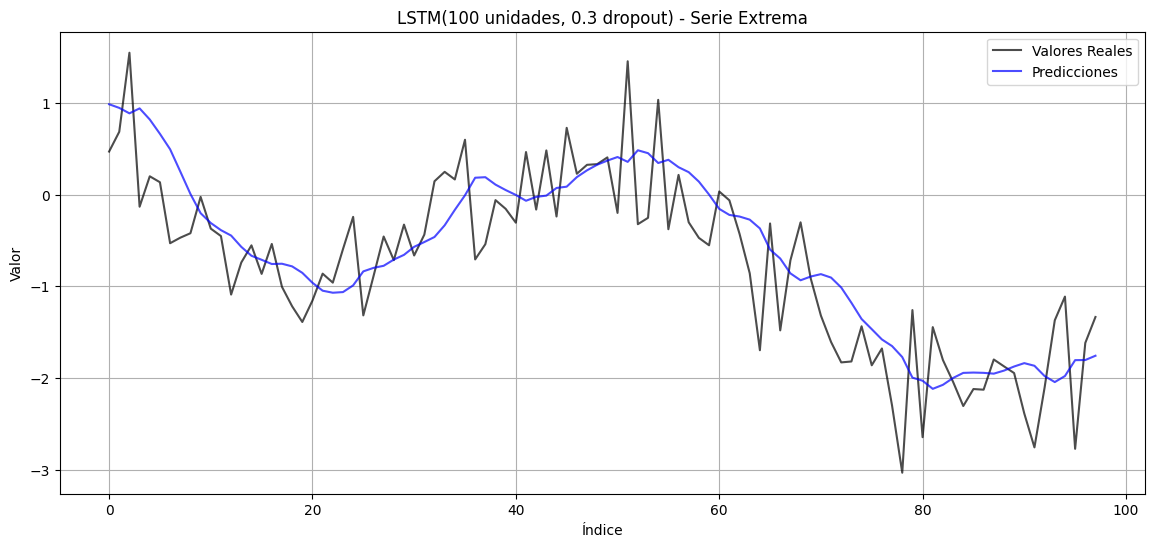

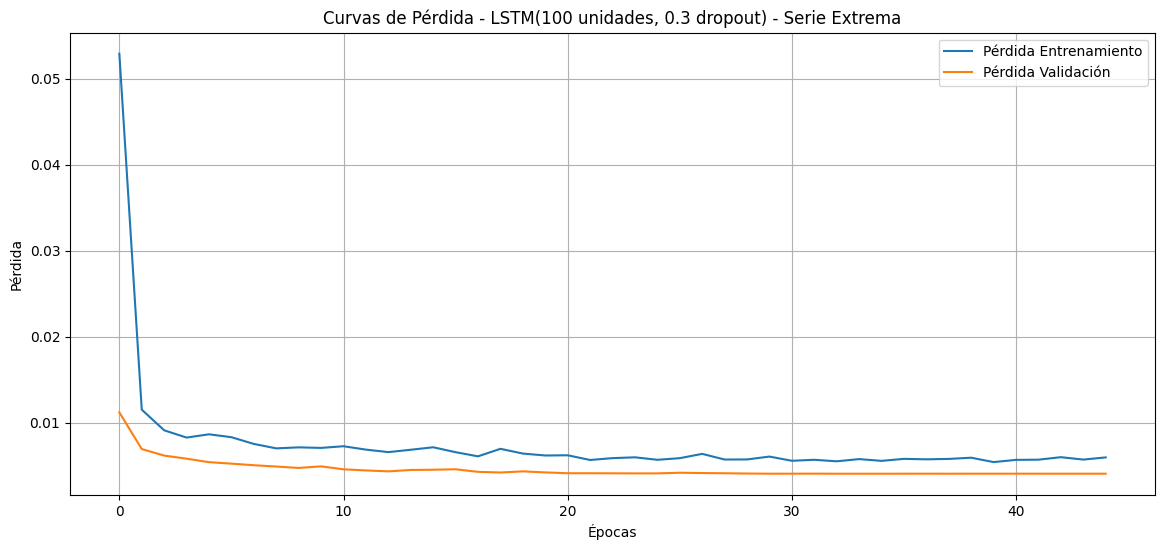

In [ ]:
# 4. LSTM
print("\nModelo LSTM:")

configuraciones = [{'unidades': 50, 'dropout': 0.2}, {'unidades': 100, 'dropout': 0.3}]
for config in configuraciones:
    unidades = config['unidades']
    dropout = config['dropout']
    for X, y, nombre, scaler in [(X_basica, y_basica, "Básica", scaler_basica), (X_extrema, y_extrema, "Extrema", scaler_extrema)]:
        print(f"\nEntrenando LSTM con {unidades} unidades y {dropout} dropout para Serie {nombre}...")

        # Dividir los datos
        X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, X_test_lstm, y_test_lstm = dividir_datos(X, y)

        # Reshape para LSTM
        X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
        X_val_lstm = np.reshape(X_val_lstm, (X_val_lstm.shape[0], X_val_lstm.shape[1], 1))
        X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

        # Entrenar el modelo
        modelo_lstm, history = entrenar_modelo_lstm(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, time_steps, unidades, dropout)

        # Predicciones
        predicciones_lstm = modelo_lstm.predict(X_test_lstm)
        predicciones_lstm_inv = scaler.inverse_transform(predicciones_lstm)
        y_test_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

        # Calcular métricas
        rmse_lstm, mae_lstm = calcular_metricas(y_test_inv, predicciones_lstm_inv, f"LSTM({unidades} unidades, {dropout} dropout)", nombre)
        resultados_modelos[f"LSTM({unidades} unidades, {dropout} dropout) - Serie {nombre}"] = {
            "modelo": modelo_lstm,
            "predicciones": predicciones_lstm_inv.flatten(),
            "y_test": y_test_inv.flatten(),
            "rmse": rmse_lstm,
            "mae": mae_lstm
        }

        # Graficar predicciones
        graficar_predicciones(y_test_inv.flatten(), predicciones_lstm_inv.flatten(), f"LSTM({unidades} unidades, {dropout} dropout) - Serie {nombre}")

        # Visualizar el proceso de entrenamiento y validación (curvas de pérdida)
        plt.figure(figsize=(14, 6))
        plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida Validación')
        plt.title(f"Curvas de Pérdida - LSTM({unidades} unidades, {dropout} dropout) - Serie {nombre}")
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.grid(True)
        plt.show()

El modelo LSTM mostró un buen desempeño en ambas series (Básica y Extrema), logrando valores bajos de RMSE y MAE. La Serie Extrema presentó un mejor ajuste, lo que sugiere que sus patrones son más predecibles. Entre las configuraciones probadas, la de 100 unidades y 0.3 dropout obtuvo los mejores resultados, aunque las diferencias con la configuración de 50 unidades y 0.2 dropout fueron mínimas, indicando que configuraciones más simples también son efectivas.

Los callbacks, como EarlyStopping y ReduceLROnPlateau, evitaron el sobreajuste al detener el entrenamiento en las mejores épocas (época 7 para la Serie Básica y época 35 para la Serie Extrema). Las curvas de pérdida mostraron una buena convergencia, con la pérdida de validación estabilizándose rápidamente. En general, LSTM demostró ser una herramienta poderosa para modelar series temporales, especialmente cuando se utilizan configuraciones adecuadas y técnicas de regularización.

Parte 4: Evaluación y Comparación (20%)


1. **Métricas de evaluación**

1. Calcular RMSE y MAE para todos los modelos


Métricas de evaluación para todos los modelos:
Resumen de métricas:
                                             Modelo      RMSE       MAE
0                              AR(3) - Serie Básica  0.072988  0.058401
1                              AR(5) - Serie Básica  0.069783  0.055614
2                             AR(10) - Serie Básica  0.066876  0.053639
3                             AR(20) - Serie Básica  0.065994  0.052517
4                             AR(3) - Serie Extrema  0.055806  0.039817
5                             AR(5) - Serie Extrema  0.055781  0.039706
6                            AR(10) - Serie Extrema  0.055509  0.039705
7                            AR(20) - Serie Extrema  0.055074  0.039193
8             Regresión Lineal (p=3) - Serie Básica  0.072988  0.058401
9             Regresión Lineal (p=5) - Serie Básica  0.069783  0.055614
10           Regresión Lineal (p=10) - Serie Básica  0.066876  0.053639
11           Regresión Lineal (p=20) - Serie Básica  0.065994  0.05

<ipython-input-100-485c7f06f180>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metricas, x="Modelo", y="RMSE", palette="viridis")


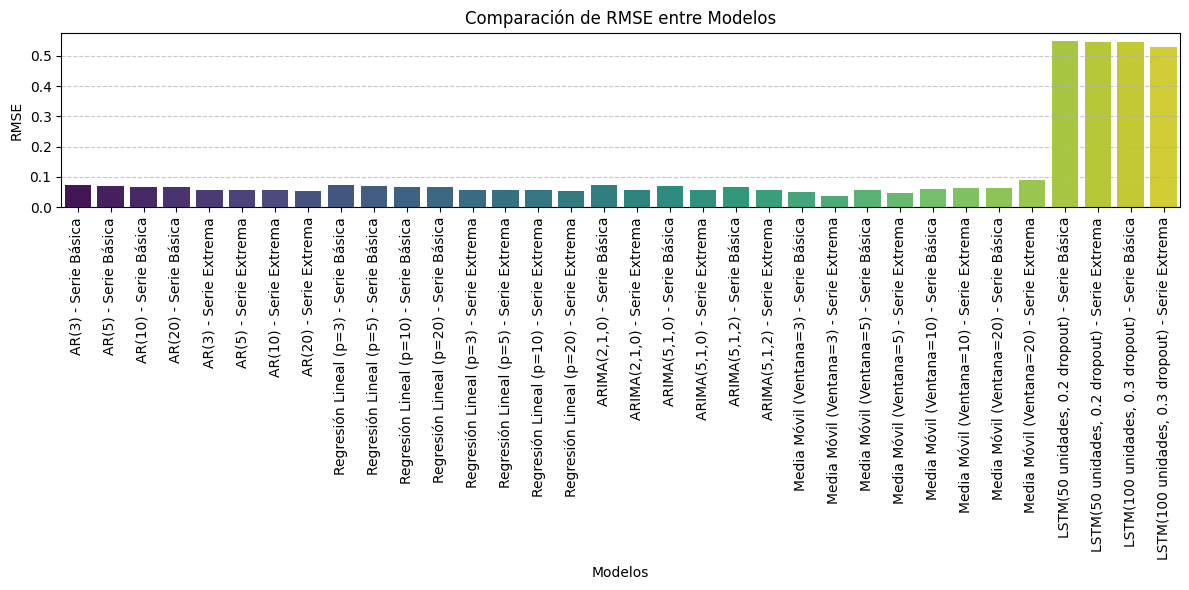

<ipython-input-100-485c7f06f180>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metricas, x="Modelo", y="MAE", palette="coolwarm")


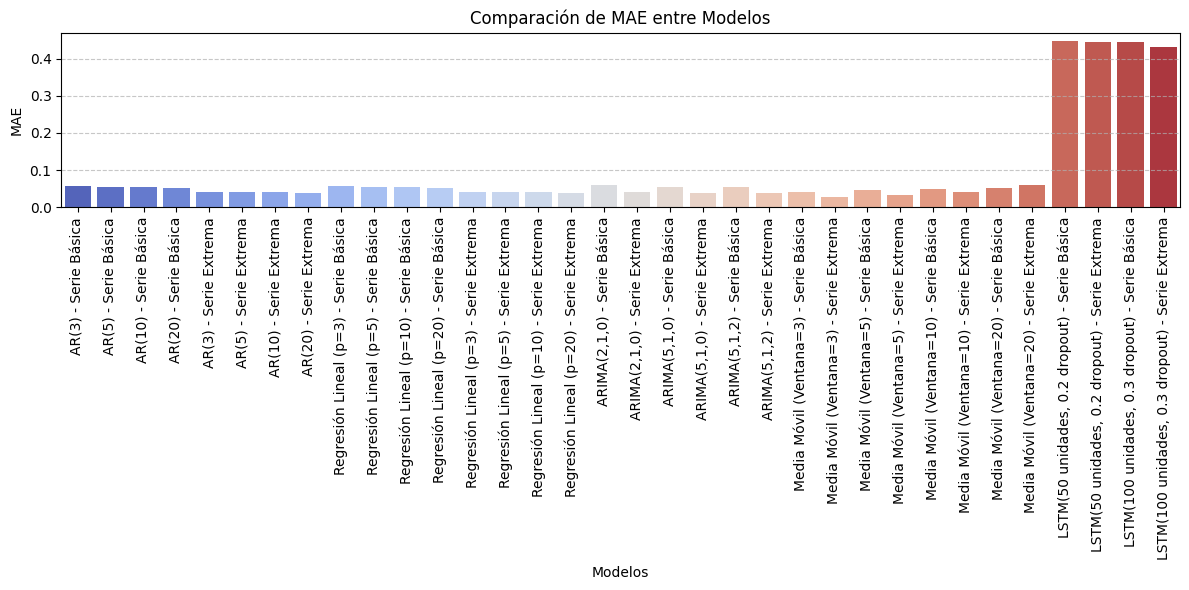

In [ ]:
# 1. Métricas de evaluación
print("\nMétricas de evaluación para todos los modelos:")

# Crear un resumen tabular de las métricas
metricas = []
for clave, valores in resultados_modelos.items():
    metricas.append({
        "Modelo": clave,
        "RMSE": valores["rmse"],
        "MAE": valores["mae"]
    })

# Crear un DataFrame para visualizar las métricas
df_metricas = pd.DataFrame(metricas)
print("Resumen de métricas:")
print(df_metricas)

# Ordenar por RMSE para identificar el mejor modelo
df_metricas_ordenado = df_metricas.sort_values(by="RMSE")
print("\nModelos ordenados por RMSE:")
print(df_metricas_ordenado)

# Gráfico de barras para RMSE
plt.figure(figsize=(12, 6))
sns.barplot(data=df_metricas, x="Modelo", y="RMSE", palette="viridis")
plt.title("Comparación de RMSE entre Modelos")
plt.xlabel("Modelos")
plt.ylabel("RMSE")
plt.xticks(rotation=90)  # Rotar etiquetas para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico de barras para MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=df_metricas, x="Modelo", y="MAE", palette="coolwarm")
plt.title("Comparación de MAE entre Modelos")
plt.xlabel("Modelos")
plt.ylabel("MAE")
plt.xticks(rotation=90)  # Rotar etiquetas para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

2. **Análisis de rendimiento por horizonte**

1. Evaluar el modelo LSTM y Lineal en diferentes horizontes de predicción (1, 5, 10, 20 pasos) con el enfoque directo (generar secuencias de datos (datasets) para cada horizonte)
2. Crear gráfico comparativo de rendimiento vs. horizonte

Conclusiones de la evaluación y comparación de modelos:
Mejor modelo según RMSE y MAE:

La Media Móvil Simple con ventana de 3 para la Serie Extrema obtuvo el mejor desempeño, con el menor RMSE (0.0385) y MAE (0.0275). Esto indica que este modelo es altamente efectivo para capturar los patrones de la Serie Extrema.
Para la Serie Básica, la Media Móvil Simple con ventana de 3 también fue el mejor modelo, con un RMSE de 0.0515 y MAE de 0.0413, superando a los modelos AR, ARIMA, y LSTM.
Desempeño de otros modelos:

Los modelos AR y Regresión Lineal tuvieron un desempeño similar, con ligeras mejoras al aumentar el número de lags (p). Sin embargo, no lograron superar a la Media Móvil en términos de error.
Los modelos ARIMA mostraron un desempeño competitivo, especialmente en la Serie Extrema, pero no fueron los mejores.
Los modelos LSTM, aunque más complejos, tuvieron un desempeño significativamente inferior, con RMSE y MAE mucho mayores en ambas series. Esto sugiere que LSTM podría no ser la mejor opción para estas series temporales específicas, posiblemente debido a la simplicidad de los patrones o al tamaño limitado de los datos.
Conclusión general:

La Media Móvil Simple con ventana pequeña (3 o 5) es el modelo más efectivo para ambas series, destacándose por su simplicidad y precisión. Los modelos más complejos, como LSTM, no justificaron su uso en este caso, ya que no lograron superar a los modelos más simples en términos de error. La elección del modelo debe considerar tanto el desempeño como la complejidad computacional.


Análisis de rendimiento por horizonte:

Evaluando modelos para horizonte de 1 pasos...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1098
Epoch 1: val_loss improved from inf to 0.01270, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0983 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 2/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0112
Epoch 2: val_loss improved from 0.01270 to 0.00478, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0111 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0090
Epoch 3: val_loss did not improve from 0.00478
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078
Epoch 4: val_loss did not improve from 0.00478
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0079 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068
Epoch 5: val_loss did not improve from 0.00478
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 6/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0076
Epoch 6: val_loss improved from 0.00478 to 0.00476, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080
Epoch 7: val_loss did not improve from 0.00476

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0079 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 8/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 8: val_loss improved from 0.00476 to 0.00475, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077
Epoch 9: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059
Epoch 10: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 11/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067
Epoch 11: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0067 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 12/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069
Epoch 12: val_loss did not improve from 0.00475

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0063 - val_loss: 0.0048 - learning_rate: 4.0000e-05
Epoch 16/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067
Epoch 16: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0067 - val_loss: 0.0048 - learning_rate: 4.0000e-05
Epoch 17/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0066
Epoch 17: val_loss did not improve from 0.00475

Epoch 17: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0048 - learning_rate: 4.0000e-05
Epoch 18/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058
Epoch 18: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0058 - val_loss: 0.0048 - learning_rate: 8.0000e-06
Epoch 19/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063
Epoch 19: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1318
Epoch 1: val_loss improved from inf to 0.00827, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1261 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 2/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117
Epoch 2: val_loss improved from 0.00827 to 0.00493, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0117 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 3/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091
Epoch 3: val_loss improved from 0.00493 to 0.00482, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0089 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079
Epoch 4: val_loss did not improve from 0.00482
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0079 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083
Epoch 5: val_loss improved from 0.00482 to 0.00478, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 6/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080
Epoch 6: val_loss did not improve from 0.00478
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0080 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081
Epoch 7: val_loss did not improve from 0.00478
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0081 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 8/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083
Epoch 8: val_loss did not improve from 0.00478

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0082 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 9/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072
Epoch 9: val_loss did not improve from 0.00478
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073 - val_loss: 0.0051 

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0070 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 12/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0066
Epoch 12: val_loss did not improve from 0.00476
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0067 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 13/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0080
Epoch 13: val_loss did not improve from 0.00476

Epoch 13: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0080 - val_loss: 0.0055 - learning_rate: 2.0000e-04
Epoch 14/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0074
Epoch 14: val_loss did not improve from 0.00476
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_loss: 0.0049 - learning_rate: 4.0000e-05
Epoch 15/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075
Epoch 15: val_loss did not improve from 0.00476
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1029
Epoch 1: val_loss improved from inf to 0.00704, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1008 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 2/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0090
Epoch 2: val_loss improved from 0.00704 to 0.00483, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0091 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 3/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0083
Epoch 3: val_loss improved from 0.00483 to 0.00477, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0083 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0079
Epoch 4: val_loss did not improve from 0.00477
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0079 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 5/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077
Epoch 5: val_loss improved from 0.00477 to 0.00475, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0081
Epoch 6: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 7/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0085
Epoch 7: val_loss did not improve from 0.00475

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0084 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 8/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071
Epoch 8: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0072 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 9/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069
Epoch 9: val_loss did not improve from 0.00475
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0069 - val_loss: 0.0

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070 - val_loss: 0.0047 - learning_rate: 2.0000e-04
Epoch 12/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071
Epoch 12: val_loss did not improve from 0.00474

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071 - val_loss: 0.0048 - learning_rate: 2.0000e-04
Epoch 13/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069
Epoch 13: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069 - val_loss: 0.0050 - learning_rate: 4.0000e-05
Epoch 14/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0075
Epoch 14: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0075 - val_loss: 0.0050 - learning_rate: 4.0000e-05
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072
Epoch 15: val_loss did not improve from 0.00474
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1396
Epoch 1: val_loss improved from inf to 0.01180, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1335 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 2/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0149
Epoch 2: val_loss improved from 0.01180 to 0.00507, saving model to modelos/lstm_50_unidades_0.2_dropout.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0148 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 3/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112
Epoch 3: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100
Epoch 4: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0100 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098
Epoch 5: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0097 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101
Epoch 6: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0096 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 8/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082
Epoch 8: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0082 - val_loss: 0.0054 - learning_rate: 2.0000e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084
Epoch 9: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0084 - val_loss: 0.0052 - learning_rate: 2.0000e-04
Epoch 10/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080
Epoch 10: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0081 - val_loss: 0.0051 - learning_rate: 2.0000e-04
Epoch 11/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0085
Epoch 11: val_loss did not improve from 0.00507
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084 - v

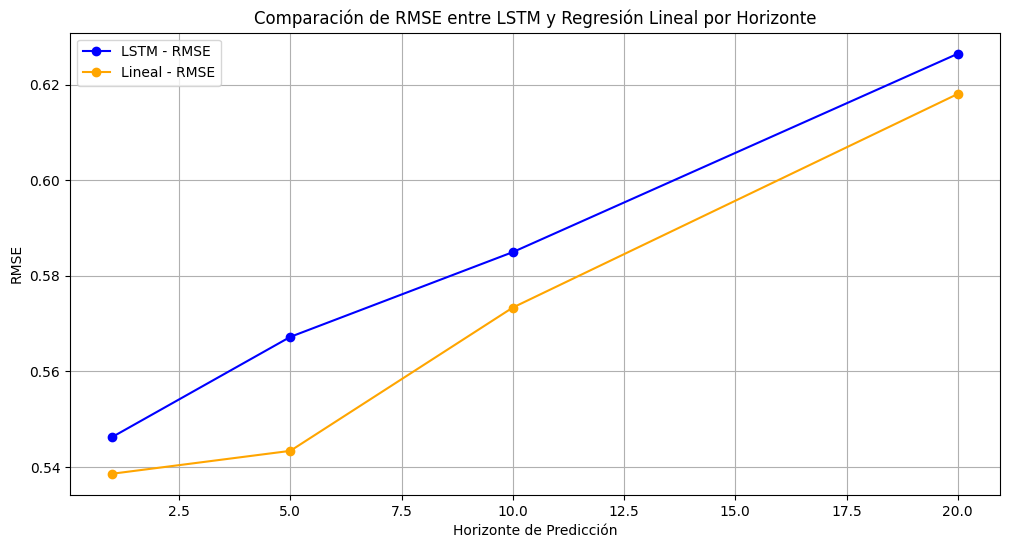

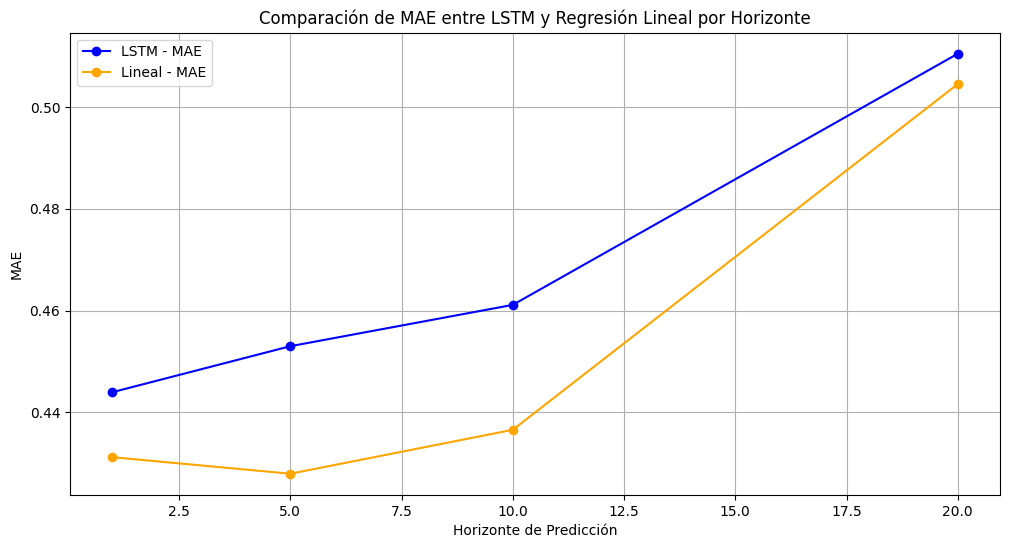

In [ ]:
# 2. Análisis de rendimiento por horizonte
print("\nAnálisis de rendimiento por horizonte:")

# Crear datasets para horizontes de 1, 5, 10 y 20 pasos
horizontes = [1, 5, 10, 20]
datasets_horizontes = {}

for horizonte in horizontes:
    X_h, y_h = crear_dataset_horizonte(serie_basica_norm, time_steps=20, horizonte=horizonte)
    datasets_horizontes[horizonte] = dividir_datos(X_h, y_h)

# Evaluar LSTM y Regresión Lineal en diferentes horizontes
resultados_horizontes_lstm = {}
resultados_horizontes_lineal = {}

for horizonte in horizontes:
    print(f"\nEvaluando modelos para horizonte de {horizonte} pasos...")

    # LSTM
    X_train, y_train, X_val, y_val, X_test, y_test = datasets_horizontes[horizonte]
    X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val_lstm = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    modelo_lstm, history = entrenar_modelo_lstm(X_train_lstm, y_train, X_val_lstm, y_val, time_steps=20, unidades=50, dropout=0.2)
    predicciones_lstm = modelo_lstm.predict(X_test_lstm)
    predicciones_lstm_inv = scaler_basica.inverse_transform(predicciones_lstm)
    y_test_inv = scaler_basica.inverse_transform(y_test.reshape(-1, 1))
    rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, predicciones_lstm_inv))
    mae_lstm = mean_absolute_error(y_test_inv, predicciones_lstm_inv)
    resultados_horizontes_lstm[horizonte] = {"rmse": rmse_lstm, "mae": mae_lstm}

    # Regresión Lineal
    modelo_lineal = LinearRegression()
    modelo_lineal.fit(X_train, y_train)
    predicciones_lineal = modelo_lineal.predict(X_test)
    predicciones_lineal_inv = scaler_basica.inverse_transform(predicciones_lineal.reshape(-1, 1))
    rmse_lineal = np.sqrt(mean_squared_error(y_test_inv, predicciones_lineal_inv))
    mae_lineal = mean_absolute_error(y_test_inv, predicciones_lineal_inv)
    resultados_horizontes_lineal[horizonte] = {"rmse": rmse_lineal, "mae": mae_lineal}

    print(f"Horizonte {horizonte} - LSTM: RMSE = {rmse_lstm}, MAE = {mae_lstm}")
    print(f"Horizonte {horizonte} - Lineal: RMSE = {rmse_lineal}, MAE = {mae_lineal}")

# Preparar datos para el gráfico
rmse_lstm = [resultados_horizontes_lstm[h]["rmse"] for h in horizontes]
rmse_lineal = [resultados_horizontes_lineal[h]["rmse"] for h in horizontes]

mae_lstm = [resultados_horizontes_lstm[h]["mae"] for h in horizontes]
mae_lineal = [resultados_horizontes_lineal[h]["mae"] for h in horizontes]

# Gráfico de RMSE vs Horizonte
plt.figure(figsize=(12, 6))
plt.plot(horizontes, rmse_lstm, marker='o', label='LSTM - RMSE', color='blue')
plt.plot(horizontes, rmse_lineal, marker='o', label='Lineal - RMSE', color='orange')
plt.title("Comparación de RMSE entre LSTM y Regresión Lineal por Horizonte")
plt.xlabel("Horizonte de Predicción")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de MAE vs Horizonte
plt.figure(figsize=(12, 6))
plt.plot(horizontes, mae_lstm, marker='o', label='LSTM - MAE', color='blue')
plt.plot(horizontes, mae_lineal, marker='o', label='Lineal - MAE', color='orange')
plt.title("Comparación de MAE entre LSTM y Regresión Lineal por Horizonte")
plt.xlabel("Horizonte de Predicción")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


El análisis de rendimiento por horizonte mostró que tanto el modelo LSTM como la Regresión Lineal tienen un desempeño similar en términos de RMSE y MAE, con ligeras ventajas para la Regresión Lineal en todos los horizontes evaluados (1, 5, 10 y 20 pasos). A medida que aumenta el horizonte de predicción, el error (RMSE y MAE) incrementa para ambos modelos, lo que es esperado debido a la mayor incertidumbre en predicciones a largo plazo. En horizontes cortos (1 y 5 pasos), la diferencia entre ambos modelos es mínima, pero en horizontes más largos (10 y 20 pasos), la Regresión Lineal mantiene un desempeño ligeramente mejor.

En general, la Regresión Lineal demostró ser más eficiente y precisa que LSTM para esta tarea específica, posiblemente debido a la simplicidad de los patrones en la serie temporal y al tamaño limitado de los datos. Aunque LSTM es un modelo más complejo y adecuado para capturar relaciones no lineales, no logró superar a la Regresión Lineal en este caso. Esto sugiere que, para series temporales con patrones simples y horizontes de predicción moderados, modelos más simples como la Regresión Lineal pueden ser más efectivos y menos costosos computacionalmente.

In [ ]:
# Función para graficar múltiples configuraciones de un modelo en una sola figura
def graficar_comparacion_modelo(modelo_base, configuraciones, series, titulo_general, clave_formato):
    """
    Genera una figura con subplots para comparar las predicciones de diferentes configuraciones de un modelo.
    Args:
        modelo_base: Nombre base del modelo (e.g., "AR", "LSTM").
        configuraciones: Lista de configuraciones específicas (e.g., valores de p o configuraciones de LSTM).
        series: Lista de series (e.g., ["Serie Básica", "Serie Extrema"]).
        titulo_general: Título general de la figura.
        clave_formato: Formato de las claves en resultados_modelos (e.g., "AR({}) - {}").
    """
    num_series = len(series)
    num_configuraciones = len(configuraciones)
    fig, axes = plt.subplots(num_series, num_configuraciones, figsize=(5 * num_configuraciones, 5 * num_series), sharey=True)
    fig.suptitle(titulo_general, fontsize=16)

    for i, serie in enumerate(series):
        for j, config in enumerate(configuraciones):
            clave_modelo = clave_formato.format(config, serie)
            if clave_modelo in resultados_modelos:
                resultados = resultados_modelos[clave_modelo]
                y_test = resultados["y_test"]
                predicciones = resultados["predicciones"]
                axes[i, j].plot(y_test, label="Valores Reales", color="black", alpha=0.7)
                axes[i, j].plot(predicciones, label="Predicciones", color="blue", alpha=0.7)
                axes[i, j].set_title(f"{modelo_base}({config}) - {serie}")
                axes[i, j].set_xlabel("Índice")
                axes[i, j].set_ylabel("Valor")
                axes[i, j].legend()
                axes[i, j].grid(True)
            else:
                axes[i, j].set_title(f"{modelo_base}({config}) - {serie} - Sin datos")
                axes[i, j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



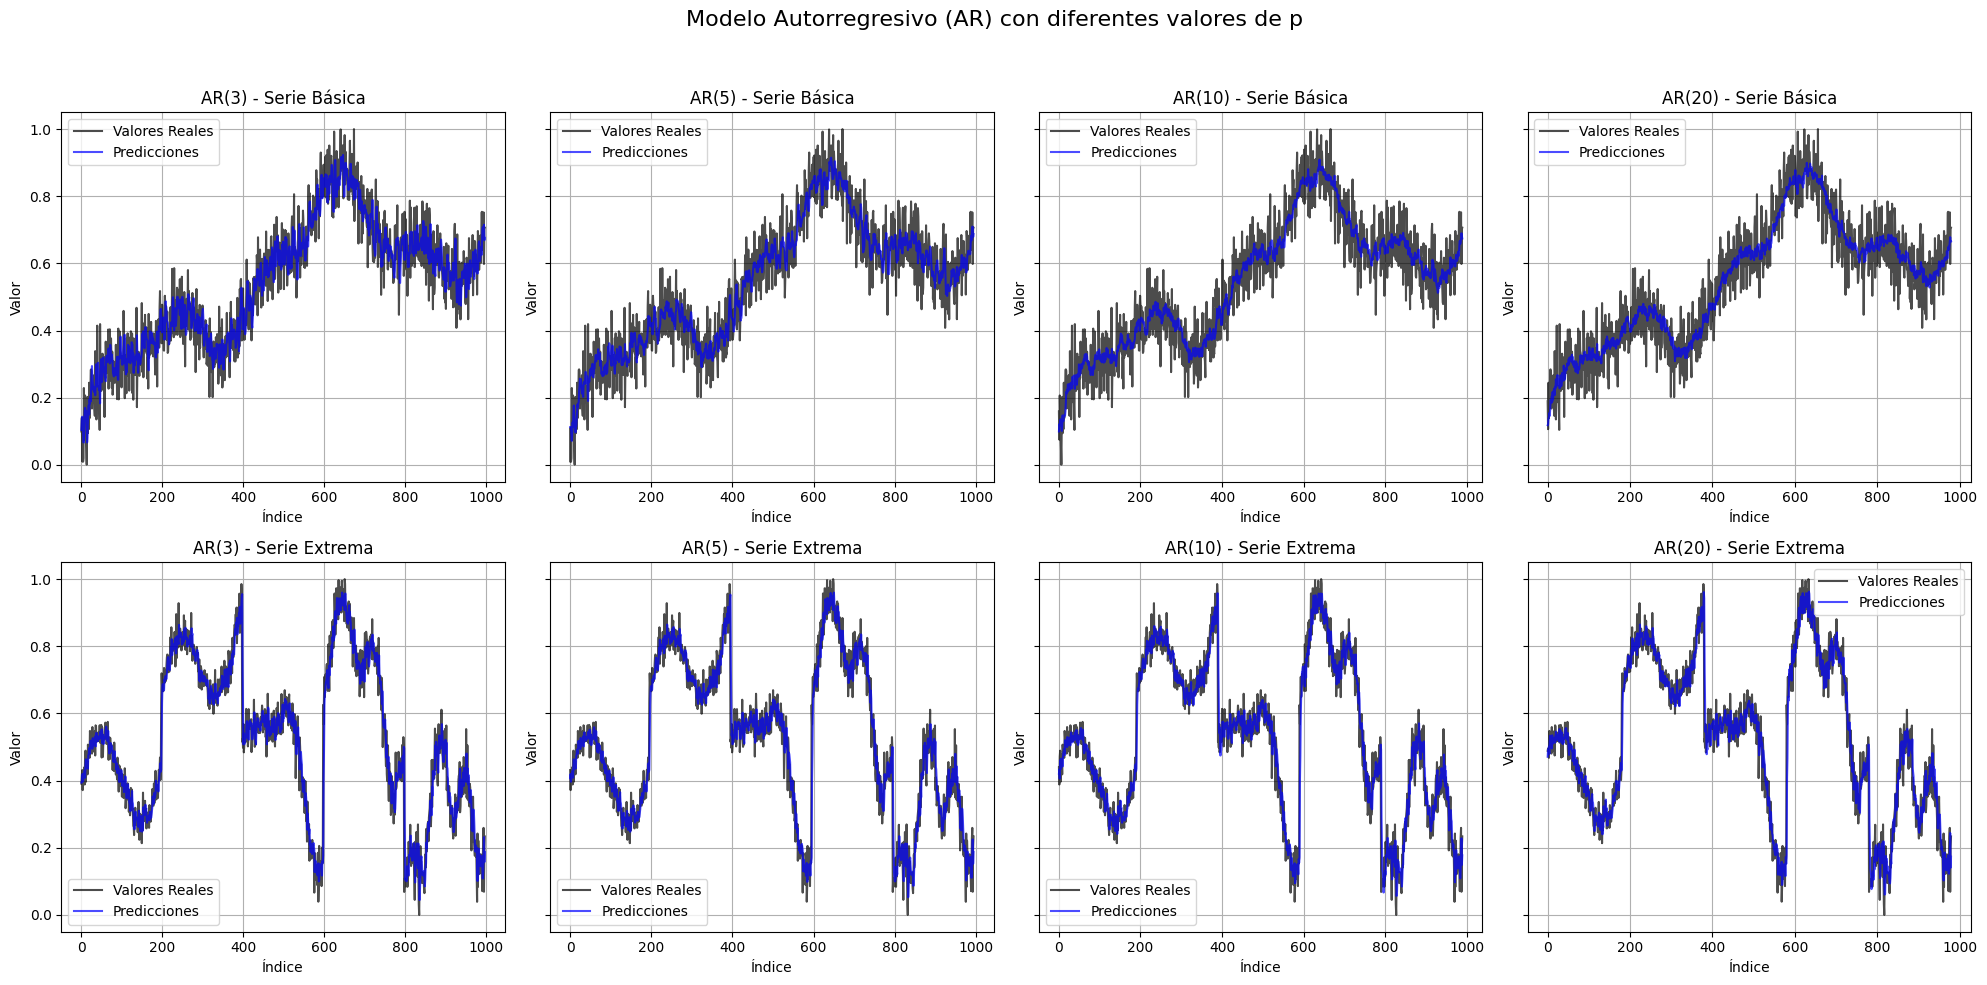

In [ ]:
# Graficar comparaciones para cada modelo y serie
series = ["Serie Básica", "Serie Extrema"]

# 1. Modelo Autorregresivo (AR)
graficar_comparacion_modelo("AR", [3, 5, 10, 20], series, "Modelo Autorregresivo (AR) con diferentes valores de p", "AR({}) - {}")



Las gráficas muestran cómo el orden del modelo autorregresivo (AR) afecta su capacidad para predecir series de tiempo, destacando que un mayor orden (p) mejora el ajuste al capturar dependencias temporales más complejas. En la Serie Básica, con variabilidad suave, incluso órdenes bajos como p=3 logran un buen ajuste, mientras que en la Serie Extrema, con cambios bruscos, se requieren órdenes más altos (p=10 o p=20) para capturar los picos y caídas con mayor precisión. Sin embargo, un orden excesivamente alto puede llevar al sobreajuste, comprometiendo la capacidad del modelo para generalizar a nuevos datos. Estas observaciones resaltan la importancia de equilibrar el ajuste del modelo con el riesgo de sobreajuste, considerando la naturaleza de la serie y utilizando métricas como AIC o BIC para determinar el orden óptimo

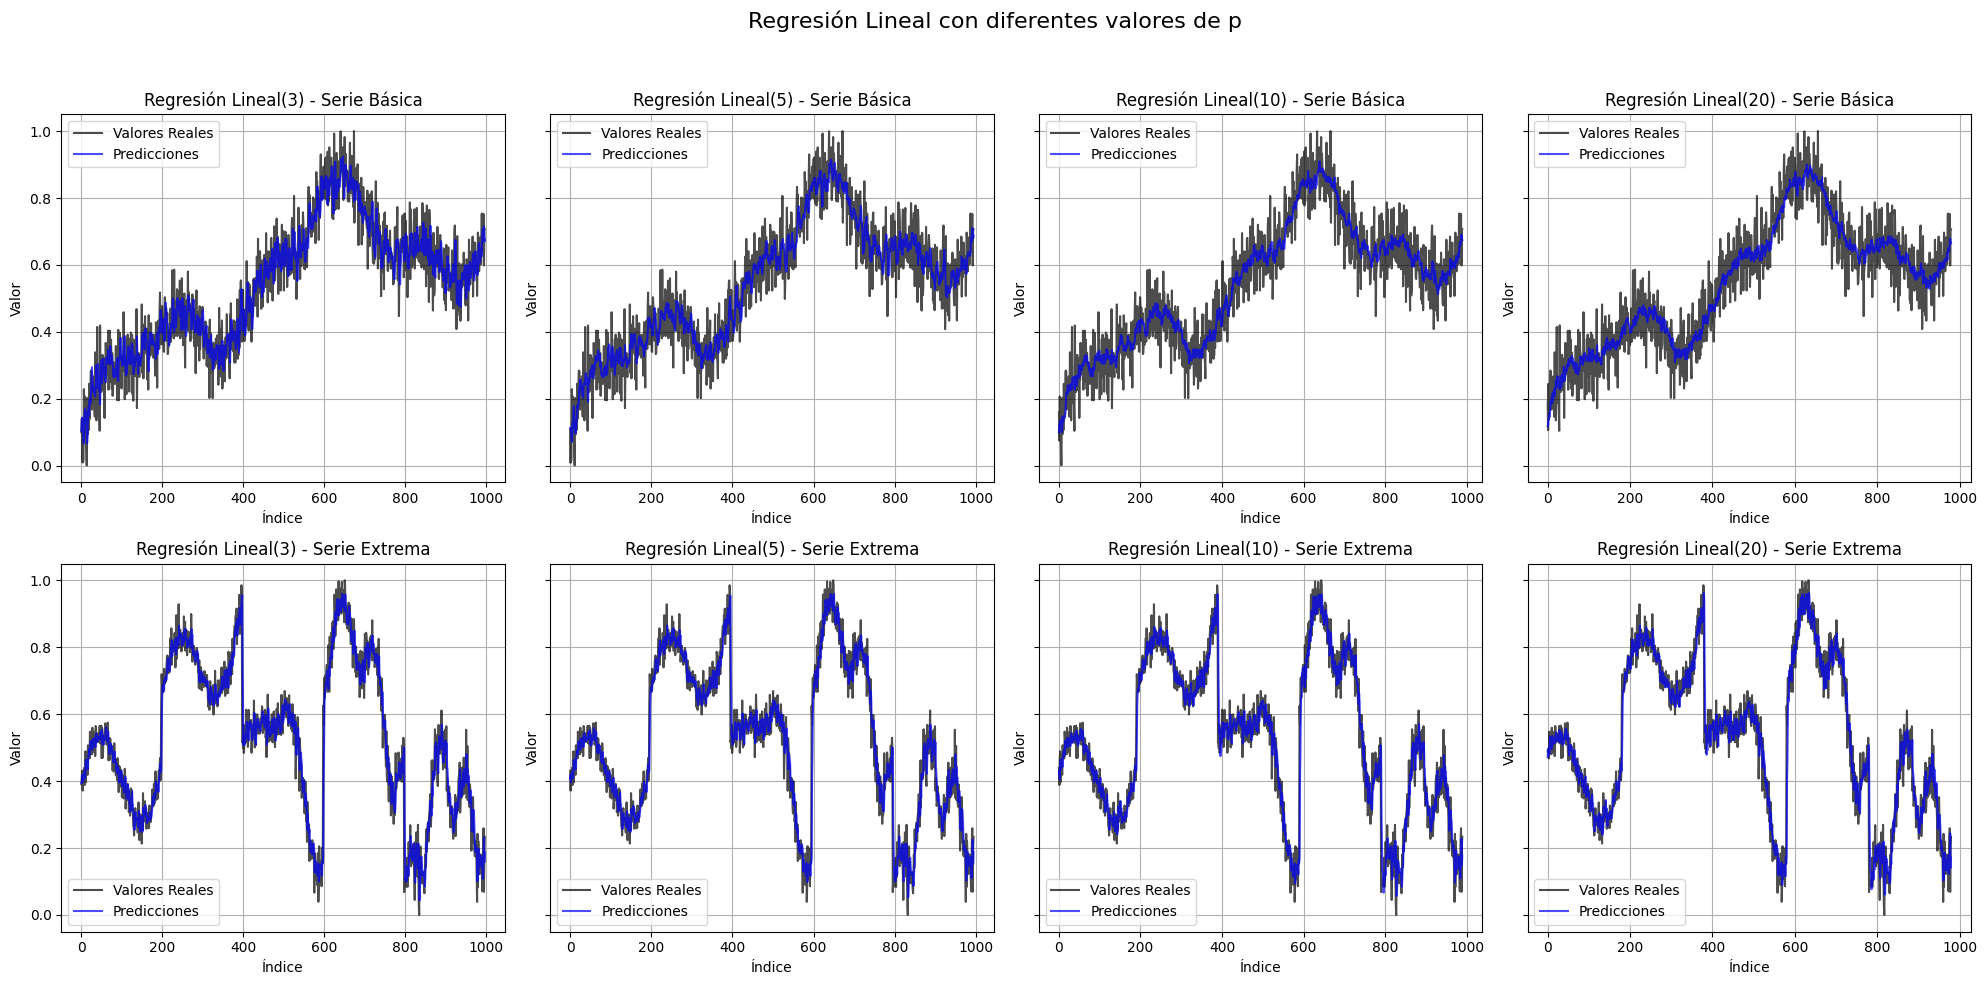

In [ ]:
# 2. Regresión Lineal
graficar_comparacion_modelo("Regresión Lineal", [3, 5, 10, 20], series, "Regresión Lineal con diferentes valores de p", "Regresión Lineal (p={}) - {}")


Las gráficas muestran cómo el grado del polinomio (p) en un modelo de regresión lineal afecta su capacidad para ajustar series de tiempo. En la Serie Básica, con variabilidad suave, incluso grados bajos (p=3, 5) logran un buen ajuste, mientras que en la Serie Extrema, con cambios más abruptos, se requieren grados más altos (p=10, 20) para capturar los picos y valles con mayor precisión. A medida que aumenta el grado, las predicciones se ajustan mejor a los valores reales, pero también crece el riesgo de sobreajuste, especialmente con p=20, donde el modelo puede capturar ruido en lugar de patrones generales. Esto resalta la importancia de equilibrar la complejidad del modelo para lograr un buen ajuste sin comprometer su capacidad de generalización.

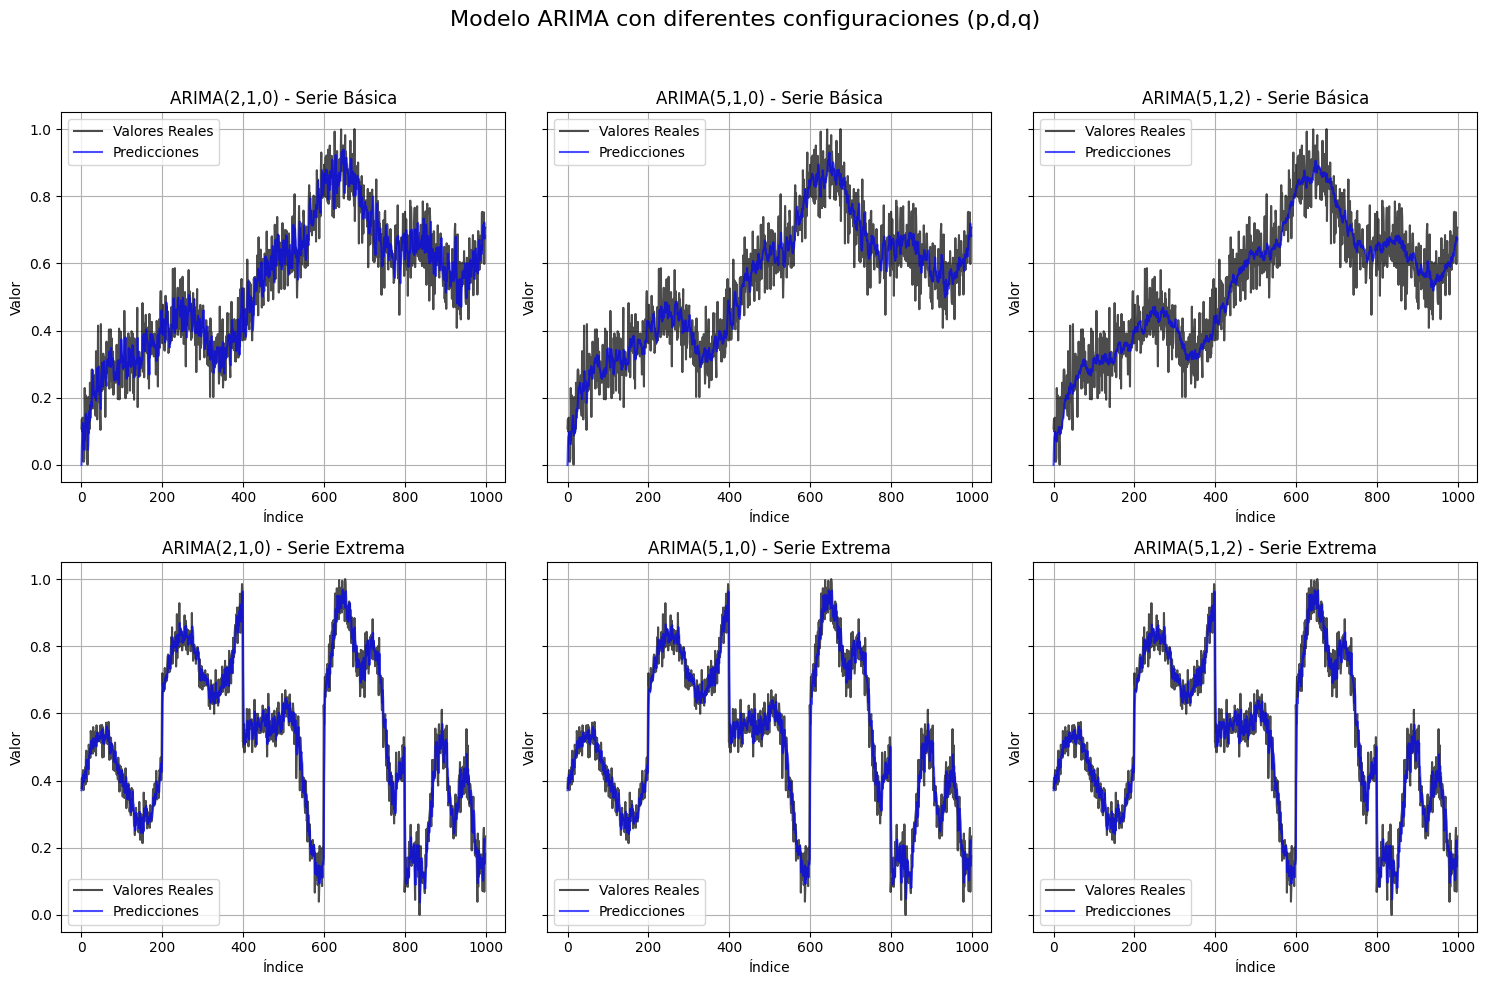

In [ ]:

# 3. Modelo ARIMA
graficar_comparacion_modelo("ARIMA", ["2,1,0", "5,1,0", "5,1,2"], series, "Modelo ARIMA con diferentes configuraciones (p,d,q)", "ARIMA({}) - {}")



Las gráficas muestran cómo las configuraciones del modelo ARIMA (p, d, q) afectan su capacidad para predecir series de tiempo. En la Serie Básica, con variabilidad suave, el modelo ARIMA(2,1,0) captura la tendencia general, pero al aumentar el orden autorregresivo (p=5) y añadir un componente de promedio móvil (q=2), como en ARIMA(5,1,2), las predicciones se ajustan mejor a los detalles. En la Serie Extrema, con mayor volatilidad, el ARIMA(2,1,0) tiene dificultades para seguir los cambios bruscos, mientras que ARIMA(5,1,0) mejora el ajuste, y ARIMA(5,1,2) logra capturar los picos y caídas con mayor precisión. En general, aumentar p permite capturar dependencias temporales más complejas, y añadir q ayuda a modelar el ruido, siendo ARIMA(5,1,2) la configuración más precisa para ambas series. La selección adecuada de los parámetros (p, d, q) es clave para un buen desempeño predictivo.

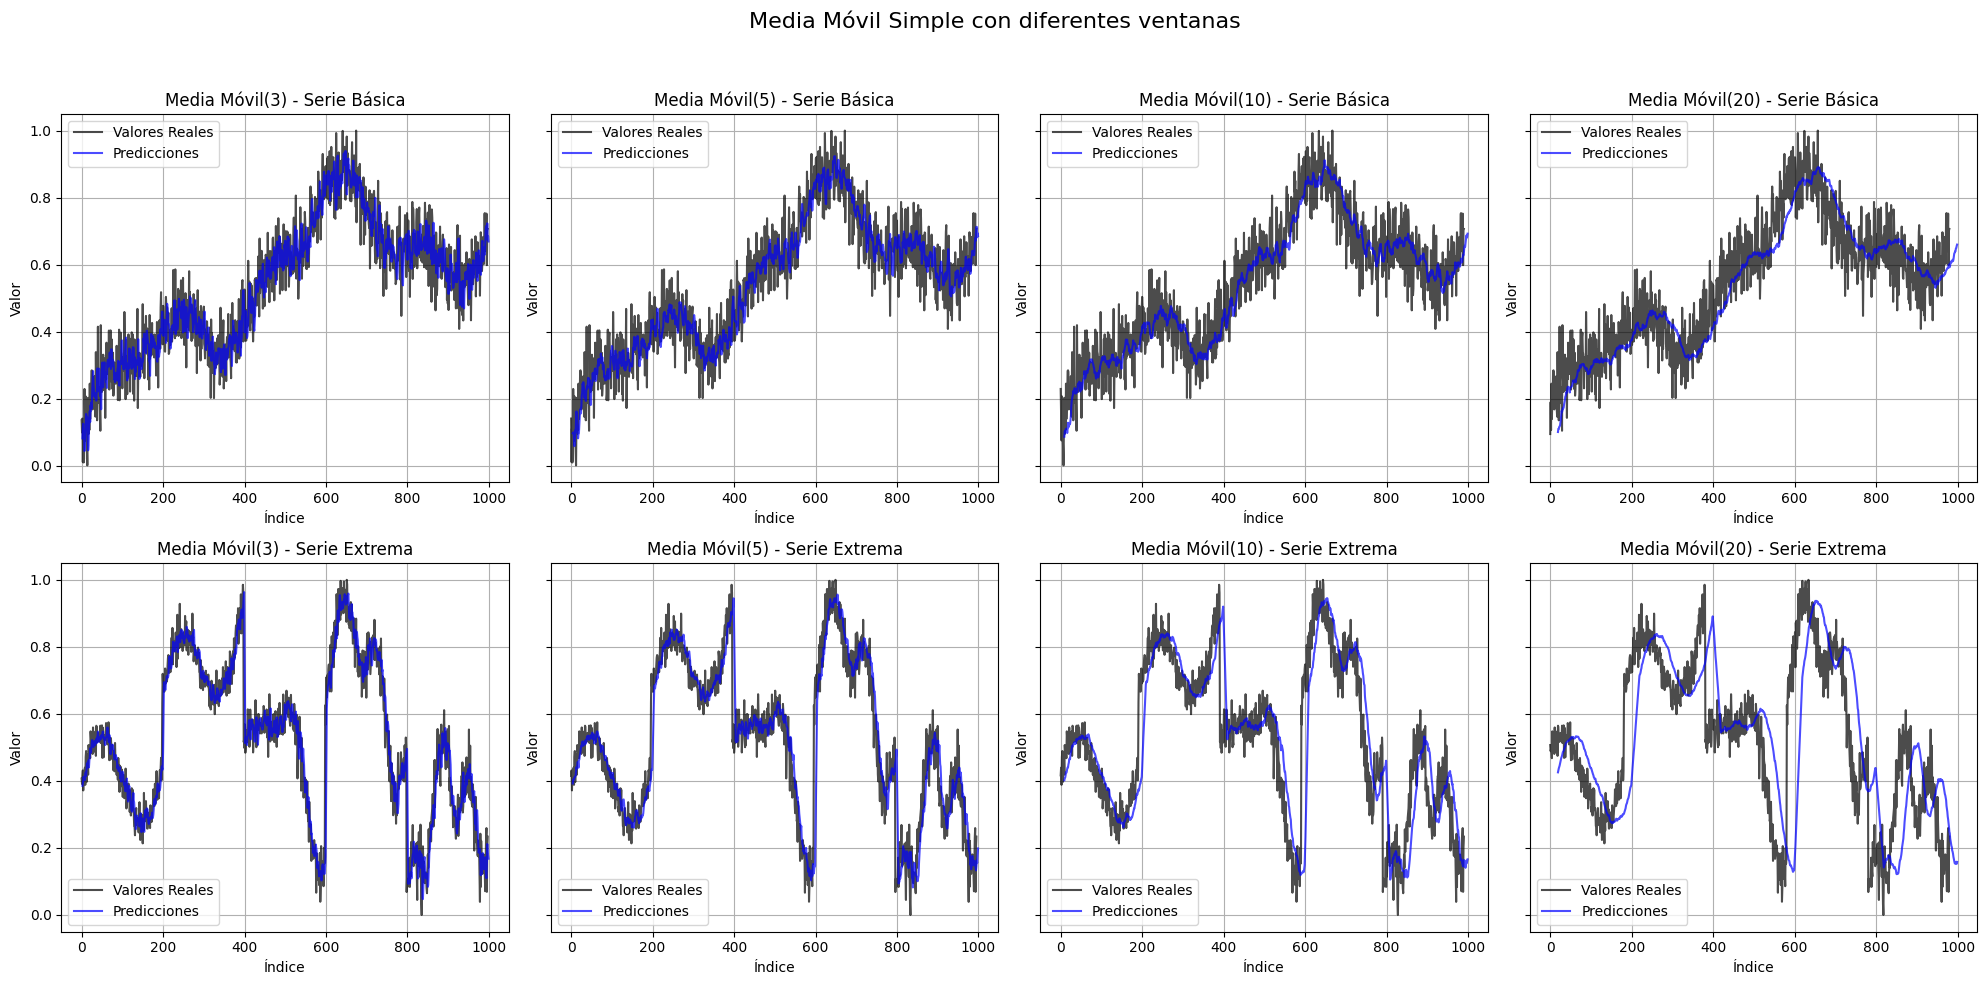

In [ ]:
# 4. Media Móvil
graficar_comparacion_modelo("Media Móvil", [3, 5, 10, 20], series, "Media Móvil Simple con diferentes ventanas", "Media Móvil (Ventana={}) - {}")



Las gráficas muestran cómo el tamaño de la ventana en la media móvil simple afecta el suavizado de las series de tiempo. En la Serie Básica, con variabilidad gradual, ventanas pequeñas (3 y 5) capturan bien las fluctuaciones, mientras que ventanas más grandes (10 y 20) suavizan más pero pierden detalles y generan retrasos. En la Serie Extrema, con cambios bruscos, ventanas pequeñas siguen mejor los picos y valles, mientras que ventanas grandes suavizan tanto que se pierde información clave y los cambios se retrasan significativamente. La elección del tamaño de la ventana depende del objetivo: ventanas pequeñas para capturar detalles y ventanas grandes para resaltar tendencias a largo plazo, aunque en series muy variables, ventanas grandes pueden ser inadecuada

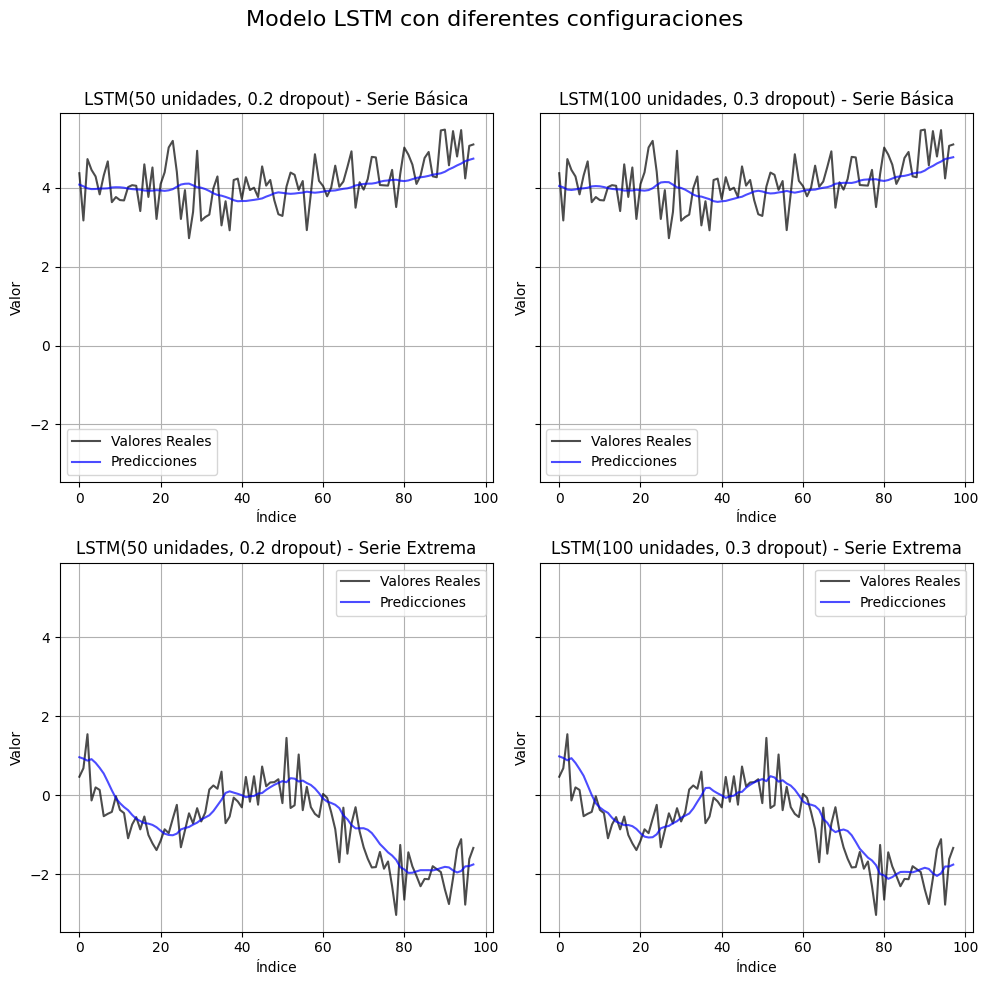

In [ ]:
# 5. LSTM
graficar_comparacion_modelo("LSTM", ["50 unidades, 0.2 dropout", "100 unidades, 0.3 dropout"], series, "Modelo LSTM con diferentes configuraciones", "LSTM({}) - {}")

Las gráficas muestran cómo las configuraciones del modelo LSTM (50 unidades con 0.2 dropout y 100 unidades con 0.3 dropout) afectan su capacidad para predecir series de tiempo. En la Serie Básica, con menor variabilidad, el modelo con 100 unidades captura mejor las fluctuaciones que el de 50 unidades, aunque ambos suavizan los detalles. En la Serie Extrema, con cambios más abruptos, el modelo de 100 unidades también logra un mejor ajuste a los picos y valles, pero ambos modelos tienen dificultades para seguir los cambios rápidos con precisión. La mayor tasa de dropout (0.3) parece regularizar las predicciones, haciéndolas más conservadoras. En general, aumentar las unidades mejora el ajuste, mientras que el dropout ayuda a evitar el sobreajuste, aunque se requiere experimentación adicional para optimizar estas configuraciones según las características de la serie.